# Análisis de Propagación de Spikes: Barrido 2D (K, rate_hz)

## Objetivo

Estudiar las probabilidades de activación de vecinos y el firing rate en función de:
- **K (acoplamiento recurrente)**: Factor de escalado de pesos sinápticos
- **rate_hz (input externo)**: Tasa de estímulo talámico

## Estrategia

1. **Barrido 2D**: Simular todas las combinaciones (K, rate_hz) → obtener (FR, P, σ)
2. **Matching por FR**: Para cada (K≠0, FR_target), encontrar K=0 con FR≈FR_target
3. **Contribución de red**: ΔP = P_coupled - P_baseline (mismo FR, diferente origen)
4. **Visualización**: Heatmaps, cortes 1D, análisis de ΔP(K, FR)

## Hipótesis

- FR ≈ a·rate_hz (relación casi lineal)
- K=0 define actividad espúrea (baseline)
- ΔP(K>0) captura la dinámica de red pura

---

## 1. Setup y Configuración

In [1]:
# from os import environ
# environ["OMP_NUM_THREADS"] = "1"
# environ["OPENBLAS_NUM_THREADS"] = "1"
# environ["MKL_NUM_THREADS"] = "1"
# environ["VECLIB_MAXIMUM_THREADS"] = "1"
# environ["NUMEXPR_NUM_THREADS"] = "1"

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import os
import sys
from pathlib import Path

# Navegación al directorio raíz del proyecto
if Path.cwd().name == 'two_populations':
    os.chdir('../..')


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from brian2 import *
from datetime import datetime
from collections import defaultdict
import pickle
from tqdm.auto import tqdm
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from loguru import logger

# Imports del proyecto
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results
from src.two_populations.helpers.logger import setup_logger

# Configurar logger
logger = setup_logger(
    experiment_name="spike_propagation_2d",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Estilo de plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

/home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO     | __main__:<module>:40 - Working directory: /home/tonicoll/Projects/izhikevich
INFO     | __main__:<module>:41 - Timestamp: 2026-01-15 22:04:22


## 2. Parámetros del Barrido

In [3]:
# =============================================================================
# CONFIGURACIÓN DEL BARRIDO
# =============================================================================

# Tamaño de red
Ne = 800
Ni = 200

# Parámetros de simulación
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 5000,
    'warmup_ms': 500
}

# Parámetros fijos de red
NETWORK_PARAMS = {
    'Ne': Ne,
    'Ni': Ni,
    'noise_exc': 0.884,
    'noise_inh': 0.60,
    'p_intra': 0.1,
    'delay': 0.0,
    'stim_start_ms': None,
    'stim_duration_ms': SIM_CONFIG['T_ms'],
    'stim_base': 1.0,
    'stim_elevated': None
}

# Rango de parámetros a barrer
K_VALUES = np.array([0.0,  10.0])  #np.array([0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0])  # 17 valores
RATE_HZ_VALUES = np.array([2, 20]) #np.array([2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20])  # 11 valores
N_TRIALS = 5
N_PROCESSES = 24

# Parámetros del análisis de propagación
PROPAGATION_CONFIG = {
    'window_ms': 4.0,         # Ventana temporal para detectar respuestas
    'min_weight': 0.05,        # Peso mínimo para considerar conexión
    'min_spikes': 5,         # Mínimo de spikes para incluir neurona
}

# Seeds
FIXED_SEED = 100
VARIABLE_SEED = 200

# Directorio de salida
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR = Path('results/spike_propagation_2d') / f'sweep_2d_{timestamp}'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Barrido configurado:")
logger.info(f"  K values: {K_VALUES}")
logger.info(f"  rate_hz values: {RATE_HZ_VALUES}")
logger.info(f"  Total combinaciones: {len(K_VALUES) * len(RATE_HZ_VALUES)}")
logger.info(f"  Simulación: {SIM_CONFIG['T_ms']}ms @ dt={SIM_CONFIG['dt_ms']}ms")
logger.info(f"  Red: {Ne}E + {Ni}I, p_intra={NETWORK_PARAMS['p_intra']}")

INFO     | __main__:<module>:52 - Barrido configurado:
INFO     | __main__:<module>:53 -   K values: [ 0. 10.]
INFO     | __main__:<module>:54 -   rate_hz values: [ 2 20]
INFO     | __main__:<module>:55 -   Total combinaciones: 4
INFO     | __main__:<module>:56 -   Simulación: 5000ms @ dt=0.1ms
INFO     | __main__:<module>:57 -   Red: 800E + 200I, p_intra=0.1


## 3. Clase de Análisis de Propagación

In [4]:
# =============================================================================
# PROPAGATION ANALYZER
# =============================================================================

class PropagationAnalyzer:
    """
    Analiza propagación forward E→E:
    Cuando neurona i dispara, ¿cuántos vecinos j responden en ventana temporal?
    
    Métricas:
        - P_transmission: probabilidad de activar vecino por spike
        - σ (sigma): branching ratio = <n_activados>
        - firing_rate: tasa de disparo poblacional (Hz)
    """
    
    def __init__(self, window_ms=5.0, min_weight=0.0, min_spikes=20):
        self.window = window_ms
        self.min_weight = min_weight
        self.min_spikes = min_spikes
        
    def extract_connectivity_E2E(self, synapses_intra, Ne, verbose=False):
        """
        Extrae grafo de conectividad E→E desde sinapsis Brian2.
        
        Returns:
            neighbors: dict {pre_idx: [post_idx_1, post_idx_2, ...]}
            weights: dict {(pre, post): weight}
        """
        neighbors = defaultdict(list)
        weights = {}
        
        pre_indices = np.array(synapses_intra.i)
        post_indices = np.array(synapses_intra.j)
        syn_weights = np.array(synapses_intra.w)
        
        # Filtro: E→E con peso > threshold
        E_to_any_mask = (pre_indices < Ne) & (syn_weights >= 0.0)  # Solo pre < Ne
        mask = E_to_any_mask & (syn_weights >= self.min_weight)
        
        for pre, post, w in zip(pre_indices[mask], post_indices[mask], syn_weights[mask]):
            neighbors[int(pre)].append(int(post))
            weights[(int(pre), int(post))] = float(w)
        
        if verbose:
            degrees = [len(v) for v in neighbors.values()]
            logger.debug(f"  E→E connections: {np.sum(mask)} (w>{self.min_weight})")
            logger.debug(f"  Out-degree: mean={np.mean(degrees):.1f}, max={np.max(degrees)}")
        
        return dict(neighbors), weights
    
    def organize_spike_times(self, spike_times_arr, spike_indices_arr):
        """
        Organiza spikes por neurona.
        
        Returns:
            spike_dict: {neuron_idx: sorted_spike_times_array}
        """
        spike_dict = defaultdict(list)
        
        for t, idx in zip(spike_times_arr, spike_indices_arr):
            spike_dict[int(idx)].append(float(t))
        
        spike_dict = {k: np.sort(v) for k, v in spike_dict.items()}
        return dict(spike_dict)
    
    def count_responses_single_spike(self, pre_spike_time, post_neuron_spikes):
        """
        Verifica si neurona post respondió en ventana [t, t+window).
        """
        if len(post_neuron_spikes) == 0:
            return False
        
        responses = post_neuron_spikes[
            (post_neuron_spikes > pre_spike_time) & 
            (post_neuron_spikes < pre_spike_time + self.window)
        ]
        return len(responses) > 0
    
    def analyze(self, spike_dict, neighbors, T_total, warmup=0.0):
        """
        Análisis principal de propagación.
        
        Args:
            spike_dict: {neuron_idx: spike_times}
            neighbors: {pre_idx: [post_idx_list]}
            T_total: duración total (ms)
            warmup: tiempo de warmup a excluir (ms)
            
        Returns:
            dict con métricas: P_transmission, sigma, firing_rate, stats
        """
        # Filtrar spikes por warmup
        spike_dict_filtered = {
            nid: times[times >= warmup] 
            for nid, times in spike_dict.items()
        }
        
        T_analysis = T_total - warmup
        
        ratios_per_spike = []
        activated_counts = []
        per_neuron_stats = {}
        
        total_spikes_analyzed = 0
        neurons_analyzed = 0
        
        for pre_idx in neighbors.keys():
            if pre_idx not in spike_dict_filtered:
                continue
            
            pre_spikes = spike_dict_filtered[pre_idx]
            
            if len(pre_spikes) < self.min_spikes:
                continue
            
            post_neighbors = neighbors[pre_idx]
            n_neighbors = len(post_neighbors)
            
            if n_neighbors == 0:
                continue
            
            neuron_ratios = []
            neuron_activated = []
            
            for spike_time in pre_spikes:
                n_activated = 0
                
                for post_idx in post_neighbors:
                    if post_idx not in spike_dict_filtered:
                        continue
                    
                    post_spikes = spike_dict_filtered[post_idx]
                    
                    if self.count_responses_single_spike(spike_time, post_spikes):
                        n_activated += 1
                
                ratio = n_activated / n_neighbors
                
                ratios_per_spike.append(ratio)
                activated_counts.append(n_activated)
                neuron_ratios.append(ratio)
                neuron_activated.append(n_activated)
                
                total_spikes_analyzed += 1
            
            per_neuron_stats[pre_idx] = {
                'n_spikes': len(pre_spikes),
                'n_neighbors': n_neighbors,
                'mean_ratio': np.mean(neuron_ratios),
                'mean_activated': np.mean(neuron_activated)
            }
            neurons_analyzed += 1
        
        # Calcular firing rate poblacional
        total_spikes = sum(len(times) for times in spike_dict_filtered.values()) if spike_dict_filtered else 0
        n_neurons = len(spike_dict_filtered)
        firing_rate = (total_spikes / n_neurons / T_analysis) * 1000.0  # Hz
        
        ratios_per_spike = np.array(ratios_per_spike)
        activated_counts = np.array(activated_counts)
        
        results = {
            'P_transmission': np.mean(ratios_per_spike) if len(ratios_per_spike) > 0 else 0.0,
            'P_transmission_std': np.std(ratios_per_spike) if len(ratios_per_spike) > 0 else 0.0,
            'sigma': np.mean(activated_counts) if len(activated_counts) > 0 else 0.0,
            'sigma_std': np.std(activated_counts) if len(activated_counts) > 0 else 0.0,
            'firing_rate': firing_rate,
            'ratio_distribution': ratios_per_spike,
            'activated_counts': activated_counts,
            'per_neuron': per_neuron_stats,
            'stats': {
                'n_neurons_analyzed': neurons_analyzed,
                'total_spikes_analyzed': total_spikes_analyzed,
                'total_spikes': total_spikes,
                'n_neurons_active': n_neurons,
                'T_analysis': T_analysis
            }
        }
        
        return results

logger.success("PropagationAnalyzer class defined")

SUCCESS  | __main__:<module>:182 - PropagationAnalyzer class defined


## 4. Función de Simulación Parametrizada

In [5]:
def run_single_simulation(k_factor, rate_hz, trial=0, verbose=False):
    """
    Ejecuta una simulación con parámetros (k_factor, rate_hz).
    
    Returns:
        dict con spike_times, spike_indices, synapses (i, j, w)
    """
    start_scope()
    
    # Crear red
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=FIXED_SEED,
        variable_seed=VARIABLE_SEED + trial,
        trial=trial
    )
    
    # Parámetros de población
    params = {
        **NETWORK_PARAMS,
        'k_exc': k_factor,
        'k_inh': k_factor * 3.9,
        'rate_hz': rate_hz
    }
    
    # Crear población A
    pop_A = network.create_population2(name='A', **params)
    
    # IMPORTANTE: record_v_dt debe ser un número válido, no None
    # Setup monitors
    network.setup_monitors(['A'], record_v_dt=0.1, sample_fraction=0.25)
    
    # IMPORTANTE: Extraer conectividad ANTES de run_simulation
    # porque después de la simulación los objetos pueden estar en scope diferente
    syn = network.populations['A']['syn_intra']
    syn_i = np.array(syn.i[:])
    syn_j = np.array(syn.j[:])
    syn_w = np.array(syn.w[:])
    
    # Ejecutar simulación
    results = network.run_simulation()
    
    # Extraer spikes INMEDIATAMENTE
    spike_times = np.array(results['A']['spike_times'])
    spike_indices = np.array(results['A']['spike_indices'])
    

    # AÑADIR: Extraer voltajes
    v_mon = network.monitors['A']['voltage']
    v_times = np.array(v_mon.t / ms)
    v_values = np.array(v_mon.v / mV)
    v_neuron_ids = v_mon.record
        
    if verbose:
        logger.info(f"  Simulation completed: {len(spike_times)} spikes")
    
    # Retornar solo arrays numpy (pickleable)
    return {
        'k': k_factor,
        'rate_hz': rate_hz,
        'trial': trial,
        'spike_times': spike_times,
        'spike_indices': spike_indices,
        'v_times': v_times,
        'v_values': v_values,
        'v_neuron_ids': np.array(v_neuron_ids),
        'synapses': {
            'i': syn_i,
            'j': syn_j,
            'w': syn_w
        }
    }

logger.success("Simulation runner function defined")

SUCCESS  | __main__:<module>:75 - Simulation runner function defined


## 5. Barrido 2D: (K, rate_hz) → (FR, P, σ)

In [6]:
# =============================================================================
# HELPER: PROCESS SIMULATION RESULTS
# =============================================================================

def process_simulation_results(sim_data):
    """
    Procesa resultados de simulación: extrae conectividad y analiza propagación.
    
    Args:
        sim_data: dict con spike_times, spike_indices, synapses, k, rate_hz, trial
        
    Returns:
        dict con métricas de propagación
    """
    # Crear analyzer
    analyzer = PropagationAnalyzer(
        window_ms=PROPAGATION_CONFIG['window_ms'],
        min_weight=PROPAGATION_CONFIG['min_weight'],
        min_spikes=PROPAGATION_CONFIG['min_spikes']
    )
    
    # Extraer conectividad E→E desde arrays
    neighbors = defaultdict(list)
    weights = {}
    
    pre_indices = sim_data['synapses']['i']
    post_indices = sim_data['synapses']['j']
    syn_weights = sim_data['synapses']['w']
    
    E2E_mask = (pre_indices < Ne) & (syn_weights >= 0.005)
    mask = E2E_mask & (syn_weights >= analyzer.min_weight)
    
    for pre, post, w in zip(pre_indices[mask], post_indices[mask], syn_weights[mask]):
        neighbors[int(pre)].append(int(post))
        weights[(int(pre), int(post))] = float(w)
    
    neighbors = dict(neighbors)
    
    # Organizar spikes
    spike_dict = analyzer.organize_spike_times(
        sim_data['spike_times'],
        sim_data['spike_indices']
    )
    
    # Analizar propagación
    prop_results = analyzer.analyze(
        spike_dict=spike_dict,
        neighbors=neighbors,
        T_total=SIM_CONFIG['T_ms'],
        warmup=SIM_CONFIG['warmup_ms']
    )
    
    # Resultado condensado
    return {
        'k': sim_data['k'],
        'rate_hz': sim_data['rate_hz'],
        'trial': sim_data['trial'],
        'firing_rate': prop_results['firing_rate'],
        'P_transmission': prop_results['P_transmission'],
        'P_transmission_std': prop_results['P_transmission_std'],
        'sigma': prop_results['sigma'],
        'sigma_std': prop_results['sigma_std'],
        'n_neurons_analyzed': prop_results['stats']['n_neurons_analyzed'],
        'total_spikes': prop_results['stats']['total_spikes']
    }
    

# =============================================================================
# TASK RUNNER (GLOBAL FUNCTION FOR MULTIPROCESSING)
# =============================================================================

def run_single_task(args):
    """Wrapper global para multiprocessing con métricas + datos raw"""
    k_val, rate_val, trial = args
    try:
        # Simulación completa
        sim_data = run_single_simulation(
            k_factor=k_val,
            rate_hz=rate_val,
            trial=trial,
            verbose=False
        )
        
        # Métricas de propagación (análisis actual)
        metrics = process_simulation_results(sim_data)
        
        # Filtrar voltajes solo excitatorias
        exc_mask = sim_data['v_neuron_ids'] < Ne
        
        # Combinar métricas + raw data
        return {
            **metrics,  # firing_rate, P_transmission, sigma, etc.
            'raw_data': {
                'spike_times': sim_data['spike_times'],
                'spike_indices': sim_data['spike_indices'],
                'v_times': sim_data['v_times'],
                'v_exc': sim_data['v_values'][exc_mask, :],
                'v_neuron_ids_exc': sim_data['v_neuron_ids'][exc_mask],
                'N_exc_sampled': int(np.sum(exc_mask))
            }
        }
    except Exception as e:
        logger.error(f"Error at K={k_val}, rate={rate_val}, trial={trial}: {str(e)}")
        return {
            'k': k_val,
            'rate_hz': rate_val,
            'trial': trial,
            'firing_rate': np.nan,
            'P_transmission': np.nan,
            'P_transmission_std': np.nan,
            'sigma': np.nan,
            'sigma_std': np.nan,
            'n_neurons_analyzed': 0,
            'total_spikes': 0,
            'raw_data': None
        }

logger.success("Helper functions defined")


# =============================================================================
# 2D SWEEP WITH MULTIPROCESSING
# =============================================================================

def run_2d_sweep(K_values, rate_hz_values, n_trials=1, n_processes=None, save_results=True):
    """
    Ejecuta barrido 2D completo con múltiples trials en paralelo.
    Ahora guarda métricas + datos raw para análisis posterior.
    """
    import multiprocessing as mp
    
    # Generar lista de tareas (k, rate_hz, trial)
    tasks = []
    for k_val in K_values:
        for rate_val in rate_hz_values:
            for trial in range(n_trials):
                tasks.append((k_val, rate_val, trial))
    
    total_sims = len(tasks)
    
    logger.info(f"Starting 2D sweep: {total_sims} simulations")
    logger.info(f"K: {K_values}")
    logger.info(f"rate_hz: {rate_hz_values}")
    logger.info(f"n_trials: {n_trials}")
    
    if n_processes is None:
        n_processes = min(N_PROCESSES, total_sims)
    
    logger.info(f"Using {n_processes} parallel processes")
    
    # Ejecutar en paralelo con progress bar
    if n_processes > 1:
        with mp.Pool(processes=n_processes) as pool:
            results_list = list(tqdm(
                pool.imap(run_single_task, tasks),
                total=total_sims,
                desc="2D Sweep (parallel)"
            ))
    else:
        # Modo secuencial (útil para debugging)
        results_list = []
        for task in tqdm(tasks, desc="2D Sweep (sequential)"):
            results_list.append(run_single_task(task))
    
    # Separar métricas de raw_data para DataFrame
    metrics_list = []
    for result in results_list:
        if result is not None:
            # Extraer solo métricas para DataFrame
            metrics = {k: v for k, v in result.items() if k != 'raw_data'}
            metrics_list.append(metrics)
    
    # Convertir métricas a DataFrame
    df_results = pd.DataFrame(metrics_list)
    
    # Guardar resultados (métricas + raw_data completo)
    if save_results:
        output_file = OUTPUT_DIR / 'results.pkl'
        with open(output_file, 'wb') as f:
            pickle.dump({
                'df_results': df_results,
                'raw_data': results_list,  # Lista completa con raw_data
                'K_values': K_values,
                'rate_hz_values': rate_hz_values,
                'n_trials': n_trials,
                'config': {
                    'SIM_CONFIG': SIM_CONFIG,
                    'NETWORK_PARAMS': NETWORK_PARAMS,
                    'PROPAGATION_CONFIG': PROPAGATION_CONFIG
                }
            }, f)
        logger.success(f"Results saved to {output_file}")
    
    logger.success(f"2D sweep completed: {len(df_results)} simulations")
    
    return df_results

logger.success("2D sweep function defined")

SUCCESS  | __main__:<module>:118 - Helper functions defined
SUCCESS  | __main__:<module>:198 - 2D sweep function defined


In [7]:
# =============================================================================
# EJECUTAR BARRIDO 2D
# =============================================================================

# NOTA: Este bloque tarda ~30-60 minutos dependiendo del hardware y n_trials
# Puedes comentar esta celda y cargar resultados previos en la siguiente sección

logger.info("Starting 2D sweep...")
logger.info(f"Total simulations: {len(K_VALUES) * len(RATE_HZ_VALUES) * N_TRIALS}")
logger.info(f"Estimated time: ~{len(K_VALUES) * len(RATE_HZ_VALUES) * N_TRIALS * 0.3:.1f} min")

df_sweep = run_2d_sweep(
    K_values=K_VALUES,
    rate_hz_values=RATE_HZ_VALUES,
    n_trials=N_TRIALS,
    n_processes=N_PROCESSES,
    save_results=True
)

# Mostrar resumen
print("\n" + "="*80)
print("SWEEP SUMMARY")
print("="*80)
print(df_sweep.describe())
print("\n" + "="*80)

# Resumen por trial
if N_TRIALS > 1:
    print("\n" + "="*80)
    print("TRIAL VARIABILITY")
    print("="*80)
    trial_stats = df_sweep.groupby('trial')[['firing_rate', 'P_transmission', 'sigma']].agg(['mean', 'std'])
    print(trial_stats)
    print("\n" + "="*80)

INFO     | __main__:<module>:8 - Starting 2D sweep...
INFO     | __main__:<module>:9 - Total simulations: 20
INFO     | __main__:<module>:10 - Estimated time: ~6.0 min
INFO     | __main__:run_2d_sweep:141 - Starting 2D sweep: 20 simulations
INFO     | __main__:run_2d_sweep:142 - K: [ 0. 10.]
INFO     | __main__:run_2d_sweep:143 - rate_hz: [ 2 20]
INFO     | __main__:run_2d_sweep:144 - n_trials: 5
INFO     | __main__:run_2d_sweep:149 - Using 24 parallel processes


2D Sweep (parallel):   0%|          | 0/20 [00:00<?, ?it/s]

SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 2, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 208, 'variable_A_current': 208, 'variable_B_current': 211}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 4, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 216, 'variable_A_current': 216, 'variable_B_current': 219}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 1, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 204, 'variable_A_current': 204, 'variable_B_current': 207}
SUCC

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# AUTOMATIC PLOTTING
# =============================================================================

def generate_summary_plots(df, output_dir):
    """Genera y guarda figuras resumen del barrido"""
    
    # Agregar por (K, rate_hz)
    df_mean = df.groupby(['k', 'rate_hz']).agg({
        'firing_rate': 'mean',
        'P_transmission': 'mean',
        'sigma': 'mean'
    }).reset_index()
    
    # Crear grids para heatmaps
    K_unique = np.sort(df_mean['k'].unique())
    rate_unique = np.sort(df_mean['rate_hz'].unique())
    
    FR_grid = df_mean.pivot(index='k', columns='rate_hz', values='firing_rate').values
    P_grid = df_mean.pivot(index='k', columns='rate_hz', values='P_transmission').values
    sigma_grid = df_mean.pivot(index='k', columns='rate_hz', values='sigma').values
    
    # 1. Heatmaps principales
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im1 = axes[0].imshow(FR_grid, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title('Firing Rate (Hz)', fontsize=14)
    axes[0].set_xlabel('rate_hz (Hz)')
    axes[0].set_ylabel('K (coupling)')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(P_grid, aspect='auto', origin='lower', cmap='plasma')
    axes[1].set_title('P_transmission', fontsize=14)
    axes[1].set_xlabel('rate_hz (Hz)')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(sigma_grid, aspect='auto', origin='lower', cmap='coolwarm')
    axes[2].set_title('σ (branching ratio)', fontsize=14)
    axes[2].set_xlabel('rate_hz (Hz)')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.savefig(output_dir / 'heatmaps.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Curvas 1D: P vs K
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for rate in [4, 8, 12, 20]:
        mask = df_mean['rate_hz'] == rate
        axes[0].plot(df_mean[mask]['k'], df_mean[mask]['P_transmission'], 
                     'o-', label=f'rate={rate}Hz', markersize=6)
    
    axes[0].set_xlabel('K (coupling)', fontsize=12)
    axes[0].set_ylabel('P_transmission', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # σ vs K
    for rate in [4, 8, 12, 20]:
        mask = df_mean['rate_hz'] == rate
        axes[1].plot(df_mean[mask]['k'], df_mean[mask]['sigma'], 
                     'o-', label=f'rate={rate}Hz', markersize=6)
    
    axes[1].set_xlabel('K (coupling)', fontsize=12)
    axes[1].set_ylabel('σ (branching ratio)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'curves_vs_K.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    logger.success(f"Figures saved to {output_dir}")

# Generar plots automáticamente
generate_summary_plots(df_sweep, OUTPUT_DIR)

# Mostrar resumen
print("\n" + "="*80)
print("SWEEP SUMMARY")
print("="*80)
print(df_sweep.describe())
print("\n" + "="*80)

# Resumen por trial
if N_TRIALS > 1:
    print("\n" + "="*80)
    print("TRIAL VARIABILITY")
    print("="*80)
    trial_stats = df_sweep.groupby('trial')[['firing_rate', 'P_transmission', 'sigma']].agg(['mean', 'std'])
    print(trial_stats)
    print("\n" + "="*80)


In [7]:
# =============================================================================
# GLOBAL FILTER: ONLY EXCITATORY AS SENDERS
# =============================================================================

def filter_excitatory_senders(spike_times, spike_indices, Ne=800):
    """
    Filtra spikes: solo neuronas excitatorias (idx < Ne) como EMISORAS.
    Post-sinápticas pueden ser cualquiera (E o I).
    """
    mask = spike_indices < Ne
    return spike_times[mask], spike_indices[mask]

logger.success("Excitatory filter defined")

SUCCESS  | __main__:<module>:13 - Excitatory filter defined


## 6. Cargar Resultados (Opcional)

In [8]:
# =============================================================================
# LOAD PREVIOUS RESULTS (OPTIONAL)
# =============================================================================

# Si ya ejecutaste el barrido antes, puedes cargar los resultados:

load_file = OUTPUT_DIR / 'sweep_2d_20260114_042146.pkl'  # <-- Editar con tu archivo
with open(load_file, 'rb') as f:
    loaded_data = pickle.load(f)
df_sweep = loaded_data['df_results']
logger.info(f"Loaded results from {load_file}")
print(df_sweep.head())

INFO     | __main__:<module>:11 - Loaded results from results/spike_propagation_2d/sweep_2d_20260114_042146.pkl


     k  rate_hz  trial  firing_rate  P_transmission  P_transmission_std  \
0  0.0        2      0     2.575610             0.0                 0.0   
1  0.0        2      1     2.485714             0.0                 0.0   
2  0.0        2      2     1.992000             0.0                 0.0   
3  0.0        2      3     2.248889             0.0                 0.0   
4  0.0        2      4     2.546341             0.0                 0.0   

   sigma  sigma_std  n_neurons_analyzed  total_spikes  
0    0.0        0.0                   0           264  
1    0.0        0.0                   0           261  
2    0.0        0.0                   0           249  
3    0.0        0.0                   0           253  
4    0.0        0.0                   0           261  


## 7. Análisis de Matching por FR

In [9]:
# =============================================================================
# NETWORK CONTRIBUTION FIX
# =============================================================================

def compute_network_contribution_fixed(df_sweep):
    """Versión corregida que maneja baseline = 0"""
    df_baseline = df_sweep[df_sweep['k'] == 0].copy()
    df_coupled = df_sweep[df_sweep['k'] > 0].copy()
    
    logger.info(f"Baseline points: {len(df_baseline)}")
    logger.info(f"Coupled points: {len(df_coupled)}")
    
    df_merged = df_coupled.merge(
        df_baseline[['rate_hz', 'trial', 'P_transmission', 'sigma', 'firing_rate']],
        on=['rate_hz', 'trial'],
        suffixes=('', '_baseline')
    )
    
    df_merged['delta_P'] = df_merged['P_transmission'] - df_merged['P_transmission_baseline']
    df_merged['delta_sigma'] = df_merged['sigma'] - df_merged['sigma_baseline']
    
    threshold = 1e-6
    df_merged['fold_change_P'] = np.where(
        df_merged['P_transmission_baseline'] > threshold,
        df_merged['P_transmission'] / df_merged['P_transmission_baseline'],
        np.nan
    )
    
    df_merged['relative_increase_P'] = df_merged['delta_P'] / (df_merged['P_transmission_baseline'] + 0.01)
    df_merged['relative_increase_sigma'] = df_merged['delta_sigma'] / (df_merged['sigma_baseline'] + 0.1)
    
    df_contribution = df_merged.groupby('k').agg({
        'delta_P': ['mean', 'std'],
        'delta_sigma': ['mean', 'std'],
        'relative_increase_P': ['mean', 'std'],
        'relative_increase_sigma': ['mean', 'std']
    }).round(4)
    
    return df_contribution, df_merged, df_baseline

# Ejecutar y asignar variables
df_contrib, df_network_contribution, df_baseline = compute_network_contribution_fixed(df_sweep)

print("\n" + "=" * 80)
print("NETWORK CONTRIBUTION (FIXED)")
print("=" * 80)
print(df_contrib)
print("=" * 80)

INFO     | __main__:compute_network_contribution_fixed:10 - Baseline points: 55
INFO     | __main__:compute_network_contribution_fixed:11 - Coupled points: 605



NETWORK CONTRIBUTION (FIXED)
     delta_P         delta_sigma         relative_increase_P          \
        mean     std        mean     std                mean     std   
k                                                                      
0.5   0.0224  0.0277      1.6067  1.9866              2.2401  2.7727   
1.0   0.0236  0.0285      1.7931  2.1581              2.3648  2.8512   
1.5   0.0256  0.0297      1.9728  2.2920              2.5557  2.9728   
2.0   0.0289  0.0322      2.2449  2.4984              2.8858  3.2157   
2.5   0.0340  0.0346      2.6570  2.7060              3.3979  3.4641   
3.0   0.0432  0.0391      3.3874  3.0616              4.3193  3.9073   
3.5   0.0567  0.0447      4.4580  3.5109              5.6738  4.4701   
4.0   0.0716  0.0547      5.6300  4.2986              7.1574  5.4656   
5.0   0.1106  0.0708      8.7248  5.5800             11.0642  7.0770   
7.0   0.1836  0.0930     14.5174  7.3515             18.3587  9.2997   
10.0  0.2696  0.0920     21.3712  

In [10]:
# =============================================================================
# DIAGNOSTIC ANALYSIS
# =============================================================================

print("\n" + "=" * 80)
print("DIAGNOSTIC CHECKS")
print("=" * 80)

# 1. Distribución de zeros
zero_P = (df_sweep['P_transmission'] == 0).sum()
zero_sigma = (df_sweep['sigma'] == 0).sum()
zero_neurons = (df_sweep['n_neurons_analyzed'] == 0).sum()

print(f"\nZERO VALUES:")
print(f"  P_transmission = 0:     {zero_P}/{len(df_sweep)} ({100*zero_P/len(df_sweep):.1f}%)")
print(f"  sigma = 0:              {zero_sigma}/{len(df_sweep)} ({100*zero_sigma/len(df_sweep):.1f}%)")
print(f"  n_neurons_analyzed = 0: {zero_neurons}/{len(df_sweep)} ({100*zero_neurons/len(df_sweep):.1f}%)")

# 2. Por condición de K
print(f"\nZEROS BY K VALUE:")
for k_val in sorted(df_sweep['k'].unique()):
    subset = df_sweep[df_sweep['k'] == k_val]
    zero_p_k = (subset['P_transmission'] == 0).sum()
    print(f"  K={k_val:5.1f}: {zero_p_k:3d}/{len(subset):3d} zeros ({100*zero_p_k/len(subset):5.1f}%)")

# 3. Por rate
print(f"\nZEROS BY RATE:")
for rate_val in sorted(df_sweep['rate_hz'].unique()):
    subset = df_sweep[df_sweep['rate_hz'] == rate_val]
    zero_p_r = (subset['P_transmission'] == 0).sum()
    print(f"  rate={rate_val:5.1f}Hz: {zero_p_r:3d}/{len(subset):3d} zeros ({100*zero_p_r/len(subset):5.1f}%)")

# 4. Trial consistency (CV)
print(f"\nTRIAL CONSISTENCY (Coefficient of Variation):")
for metric in ['firing_rate', 'P_transmission', 'sigma']:
    cv_values = []
    for k_val in df_sweep['k'].unique():
        for rate_val in df_sweep['rate_hz'].unique():
            subset = df_sweep[(df_sweep['k'] == k_val) & (df_sweep['rate_hz'] == rate_val)]
            if len(subset) > 1 and subset[metric].mean() > 0:
                cv = subset[metric].std() / subset[metric].mean()
                cv_values.append(cv)
    
    if len(cv_values) > 0:
        print(f"  {metric:20s}: CV = {np.mean(cv_values):.4f} ± {np.std(cv_values):.4f}")

print("\n" + "=" * 80)


DIAGNOSTIC CHECKS

ZERO VALUES:
  P_transmission = 0:     223/660 (33.8%)
  sigma = 0:              223/660 (33.8%)
  n_neurons_analyzed = 0: 201/660 (30.5%)

ZEROS BY K VALUE:
  K=  0.0:  55/ 55 zeros (100.0%)
  K=  0.5:  18/ 55 zeros ( 32.7%)
  K=  1.0:  19/ 55 zeros ( 34.5%)
  K=  1.5:  19/ 55 zeros ( 34.5%)
  K=  2.0:  19/ 55 zeros ( 34.5%)
  K=  2.5:  17/ 55 zeros ( 30.9%)
  K=  3.0:  16/ 55 zeros ( 29.1%)
  K=  3.5:  14/ 55 zeros ( 25.5%)
  K=  4.0:  16/ 55 zeros ( 29.1%)
  K=  5.0:  15/ 55 zeros ( 27.3%)
  K=  7.0:  10/ 55 zeros ( 18.2%)
  K= 10.0:   5/ 55 zeros (  9.1%)

ZEROS BY RATE:
  rate=  2.0Hz:  60/ 60 zeros (100.0%)
  rate=  3.0Hz:  55/ 60 zeros ( 91.7%)
  rate=  4.0Hz:  47/ 60 zeros ( 78.3%)
  rate=  5.0Hz:  26/ 60 zeros ( 43.3%)
  rate=  6.0Hz:   5/ 60 zeros (  8.3%)
  rate=  7.0Hz:   5/ 60 zeros (  8.3%)
  rate=  8.0Hz:   5/ 60 zeros (  8.3%)
  rate= 10.0Hz:   5/ 60 zeros (  8.3%)
  rate= 12.0Hz:   5/ 60 zeros (  8.3%)
  rate= 15.0Hz:   5/ 60 zeros (  8.3%)
  rate= 

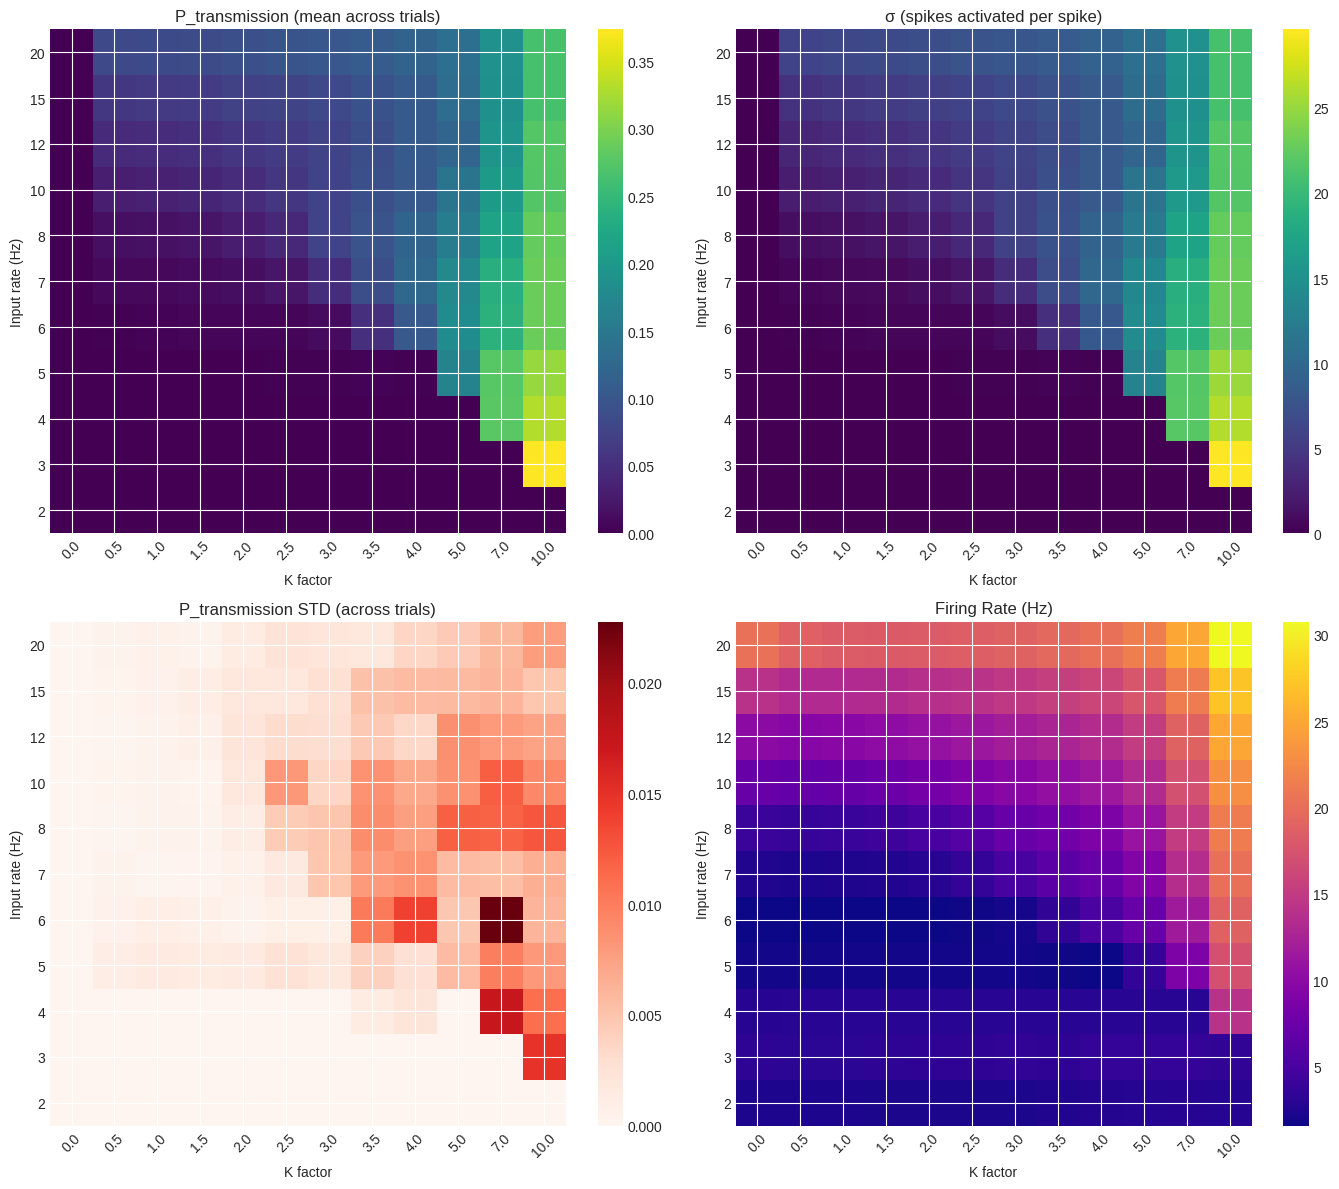

SUCCESS  | __main__:<module>:74 - Heatmaps generated


In [11]:
# =============================================================================
# VISUALIZATION: 2D HEATMAPS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Preparar datos agregados
df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).reset_index()

df_agg.columns = ['k', 'rate_hz', 'P_mean', 'P_std', 'sigma_mean', 'sigma_std', 'FR_mean']

# Crear pivot tables
pivot_P = df_agg.pivot(index='rate_hz', columns='k', values='P_mean')
pivot_sigma = df_agg.pivot(index='rate_hz', columns='k', values='sigma_mean')
pivot_P_std = df_agg.pivot(index='rate_hz', columns='k', values='P_std')
pivot_FR = df_agg.pivot(index='rate_hz', columns='k', values='FR_mean')

# 1. P_transmission
ax = axes[0, 0]
im = ax.imshow(pivot_P.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_P.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P.columns], rotation=45)
ax.set_yticks(range(len(pivot_P.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission (mean across trials)')
plt.colorbar(im, ax=ax)

# 2. Sigma
ax = axes[0, 1]
im = ax.imshow(pivot_sigma.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_sigma.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_sigma.columns], rotation=45)
ax.set_yticks(range(len(pivot_sigma.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_sigma.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('σ (spikes activated per spike)')
plt.colorbar(im, ax=ax)

# 3. Variabilidad de P_transmission
ax = axes[1, 0]
im = ax.imshow(pivot_P_std.values, aspect='auto', cmap='Reds', origin='lower')
ax.set_xticks(range(len(pivot_P_std.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P_std.columns], rotation=45)
ax.set_yticks(range(len(pivot_P_std.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P_std.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission STD (across trials)')
plt.colorbar(im, ax=ax)

# 4. Firing rate
ax = axes[1, 1]
im = ax.imshow(pivot_FR.values, aspect='auto', cmap='plasma', origin='lower')
ax.set_xticks(range(len(pivot_FR.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_FR.columns], rotation=45)
ax.set_yticks(range(len(pivot_FR.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_FR.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('Firing Rate (Hz)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Heatmaps generated")

In [13]:
# =============================================================================
# FILTER USEFUL DATA FOR EXTENDED ANALYSIS
# =============================================================================

# Criterios de filtrado
MIN_RATE = 5  # Hz
MIN_K = 0.5   # Excluir K=0 (baseline)
MIN_NEURONS = 100  # Mínimo de neuronas analizadas

df_filtered = df_sweep[
    (df_sweep['rate_hz'] >= MIN_RATE) &
    (df_sweep['k'] >= MIN_K) &
    (df_sweep['n_neurons_analyzed'] >= MIN_NEURONS)
].copy()

print(f"\nFILTERED DATA:")
print(f"  Original:  {len(df_sweep)} simulations")
print(f"  Filtered:  {len(df_filtered)} simulations ({100*len(df_filtered)/len(df_sweep):.1f}%)")
print(f"  Removed:   {len(df_sweep) - len(df_filtered)} simulations")

# Verificar zeros en datos filtrados
zero_P_filt = (df_filtered['P_transmission'] == 0).sum()
zero_sigma_filt = (df_filtered['sigma'] == 0).sum()

print(f"\nZEROS IN FILTERED DATA:")
print(f"  P_transmission = 0: {zero_P_filt}/{len(df_filtered)} ({100*zero_P_filt/len(df_filtered):.1f}%)")
print(f"  sigma = 0:          {zero_sigma_filt}/{len(df_filtered)} ({100*zero_sigma_filt/len(df_filtered):.1f}%)")

# Estadísticas de datos filtrados
print(f"\nFILTERED DATA STATISTICS:")
print(df_filtered[['P_transmission', 'sigma', 'firing_rate']].describe())

logger.success("Data filtered - ready for extended analysis")

SUCCESS  | __main__:<module>:33 - Data filtered - ready for extended analysis



FILTERED DATA:
  Original:  660 simulations
  Filtered:  372 simulations (56.4%)
  Removed:   288 simulations

ZEROS IN FILTERED DATA:
  P_transmission = 0: 0/372 (0.0%)
  sigma = 0:          0/372 (0.0%)

FILTERED DATA STATISTICS:
       P_transmission       sigma  firing_rate
count      372.000000  372.000000   372.000000
mean         0.114786    9.013891    12.487048
std          0.082946    6.608170     6.605104
min          0.007235    0.525267     1.971242
25%          0.052816    4.117056     7.194600
50%          0.090121    7.004182    11.871800
75%          0.168883   13.316677    18.096600
max          0.328021   26.006814    30.961200


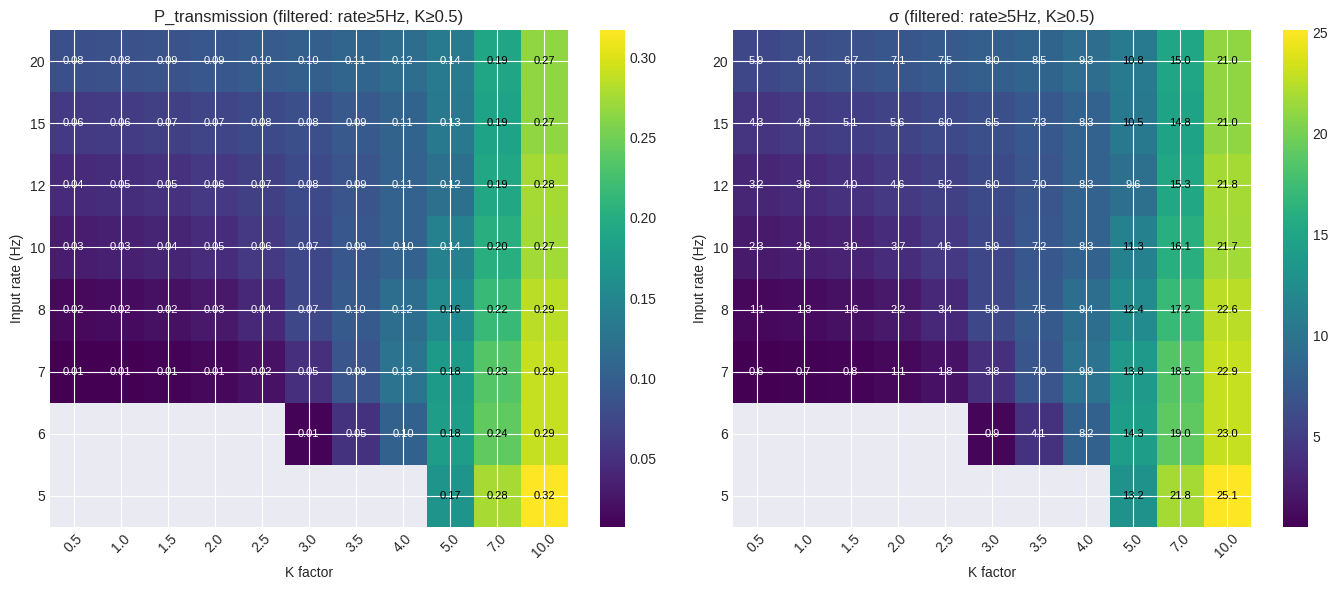

SUCCESS  | __main__:<module>:60 - Filtered heatmaps generated


In [14]:
# =============================================================================
# HEATMAPS - FILTERED DATA ONLY
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Agregar datos filtrados
df_agg_filt = df_filtered.groupby(['k', 'rate_hz']).agg({
    'P_transmission': 'mean',
    'sigma': 'mean'
}).reset_index()

pivot_P_filt = df_agg_filt.pivot(index='rate_hz', columns='k', values='P_transmission')
pivot_sigma_filt = df_agg_filt.pivot(index='rate_hz', columns='k', values='sigma')

# 1. P_transmission (filtered)
ax = axes[0]
im = ax.imshow(pivot_P_filt.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_P_filt.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P_filt.columns], rotation=45)
ax.set_yticks(range(len(pivot_P_filt.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P_filt.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission (filtered: rate≥5Hz, K≥0.5)')
plt.colorbar(im, ax=ax)

# Añadir valores en celdas
for i in range(len(pivot_P_filt.index)):
    for j in range(len(pivot_P_filt.columns)):
        val = pivot_P_filt.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                   color='white' if val < 0.15 else 'black', fontsize=8)

# 2. Sigma (filtered)
ax = axes[1]
im = ax.imshow(pivot_sigma_filt.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_sigma_filt.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_sigma_filt.columns], rotation=45)
ax.set_yticks(range(len(pivot_sigma_filt.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_sigma_filt.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('σ (filtered: rate≥5Hz, K≥0.5)')
plt.colorbar(im, ax=ax)

# Añadir valores
for i in range(len(pivot_sigma_filt.index)):
    for j in range(len(pivot_sigma_filt.columns)):
        val = pivot_sigma_filt.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.1f}', ha='center', va='center',
                   color='white' if val < 10 else 'black', fontsize=8)

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Filtered heatmaps generated")

In [14]:
# =============================================================================
# QUANTITATIVE ANALYSIS OF TRENDS
# =============================================================================

print("\n" + "=" * 80)
print("QUANTITATIVE ANALYSIS")
print("=" * 80)

# 1. Dependencia con K (agregando sobre rates)
print("\n1. EFFECT OF K (averaged over rates ≥5Hz):")
df_by_k = df_filtered.groupby('k').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).round(3)
print(df_by_k)

# 2. Dependencia con rate (agregando sobre K)
print("\n2. EFFECT OF RATE (averaged over K≥0.5):")
df_by_rate = df_filtered.groupby('rate_hz').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).round(3)
print(df_by_rate)

# 3. Saturación de K
print("\n3. SATURATION ANALYSIS:")
k_values = sorted(df_filtered['k'].unique())
P_by_k = [df_filtered[df_filtered['k'] == k]['P_transmission'].mean() for k in k_values]
sigma_by_k = [df_filtered[df_filtered['k'] == k]['sigma'].mean() for k in k_values]

# Fold-increase relativo a K=0.5
P_fold = np.array(P_by_k) / P_by_k[0]
sigma_fold = np.array(sigma_by_k) / sigma_by_k[0]

for k, p_fold, s_fold in zip(k_values, P_fold, sigma_fold):
    print(f"  K={k:4.1f}: P×{p_fold:.2f}, σ×{s_fold:.2f} (relative to K=0.5)")

# 4. Saturación threshold
saturation_k = None
for i in range(1, len(k_values)):
    increase_p = (P_by_k[i] - P_by_k[i-1]) / P_by_k[i-1]
    if increase_p < 0.15:  # <15% increase
        saturation_k = k_values[i]
        break

print(f"\n  Saturation starts at K ≈ {saturation_k if saturation_k else 'not reached'}")
print(f"  (defined as <15% increase from previous K)")

print("\n" + "=" * 80)


QUANTITATIVE ANALYSIS

1. EFFECT OF K (averaged over rates ≥5Hz):
     P_transmission          sigma        firing_rate
               mean    std    mean    std        mean
k                                                    
0.5           0.040  0.026   2.902  1.877       9.150
1.0           0.043  0.026   3.226  1.995       9.123
1.5           0.046  0.026   3.549  2.027       9.358
2.0           0.052  0.026   4.046  2.055       9.813
2.5           0.061  0.024   4.755  1.890      10.465
3.0           0.073  0.022   5.697  1.756      10.719
3.5           0.089  0.017   6.956  1.375      10.868
4.0           0.112  0.011   8.807  0.871      11.817
5.0           0.152  0.021  11.997  1.690      12.334
7.0           0.218  0.031  17.222  2.465      16.472
10.0          0.283  0.018  22.401  1.400      22.967

2. EFFECT OF RATE (averaged over K≥0.5):
        P_transmission          sigma        firing_rate
                  mean    std    mean    std        mean
rate_hz              

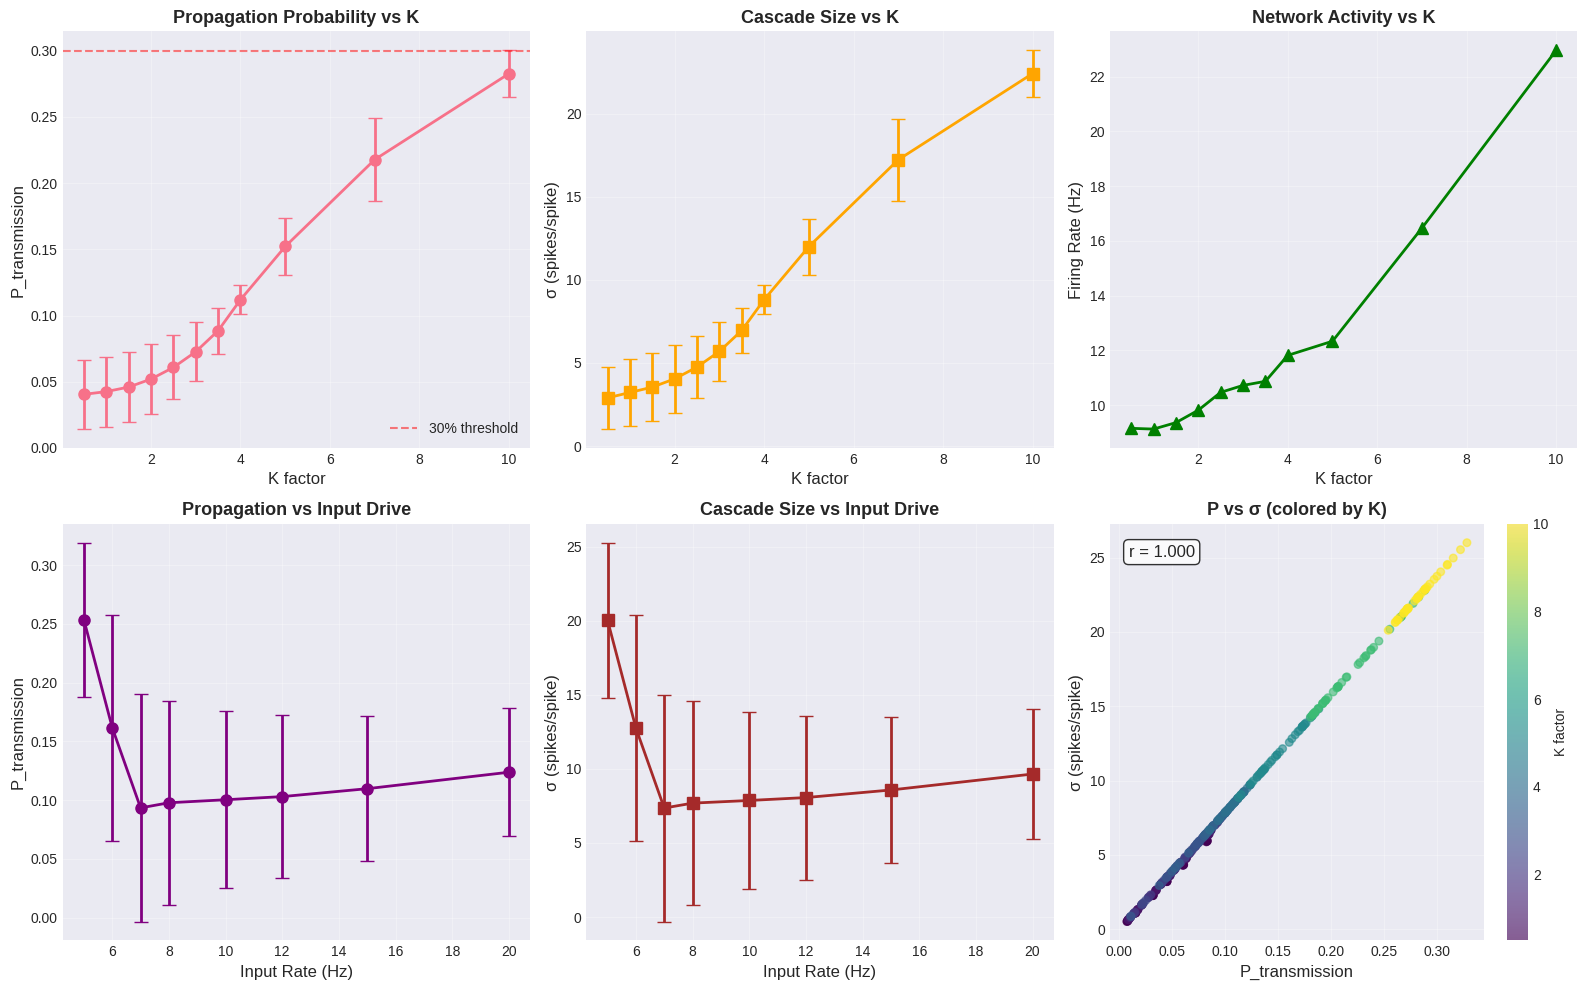

SUCCESS  | __main__:<module>:93 - Trend analysis plots generated


In [15]:
# =============================================================================
# VISUALIZATION: TRENDS AND SCALING
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Preparar datos agregados
df_by_k = df_filtered.groupby('k').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).reset_index()

df_by_rate = df_filtered.groupby('rate_hz').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).reset_index()

# Row 1: K dependence
# 1. P_transmission vs K
ax = axes[0, 0]
ax.errorbar(df_by_k['k'], df_by_k['P_transmission']['mean'], 
           yerr=df_by_k['P_transmission']['std'], 
           marker='o', capsize=5, linewidth=2, markersize=8)
ax.set_xlabel('K factor', fontsize=12)
ax.set_ylabel('P_transmission', fontsize=12)
ax.set_title('Propagation Probability vs K', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.axhline(0.3, color='red', linestyle='--', alpha=0.5, label='30% threshold')
ax.legend()

# 2. Sigma vs K
ax = axes[0, 1]
ax.errorbar(df_by_k['k'], df_by_k['sigma']['mean'],
           yerr=df_by_k['sigma']['std'],
           marker='s', capsize=5, linewidth=2, markersize=8, color='orange')
ax.set_xlabel('K factor', fontsize=12)
ax.set_ylabel('σ (spikes/spike)', fontsize=12)
ax.set_title('Cascade Size vs K', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# 3. Firing rate vs K
ax = axes[0, 2]
ax.plot(df_by_k['k'], df_by_k['firing_rate']['mean'],
       marker='^', linewidth=2, markersize=8, color='green')
ax.set_xlabel('K factor', fontsize=12)
ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
ax.set_title('Network Activity vs K', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Row 2: Rate dependence
# 4. P_transmission vs rate
ax = axes[1, 0]
ax.errorbar(df_by_rate['rate_hz'], df_by_rate['P_transmission']['mean'],
           yerr=df_by_rate['P_transmission']['std'],
           marker='o', capsize=5, linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Input Rate (Hz)', fontsize=12)
ax.set_ylabel('P_transmission', fontsize=12)
ax.set_title('Propagation vs Input Drive', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# 5. Sigma vs rate
ax = axes[1, 1]
ax.errorbar(df_by_rate['rate_hz'], df_by_rate['sigma']['mean'],
           yerr=df_by_rate['sigma']['std'],
           marker='s', capsize=5, linewidth=2, markersize=8, color='brown')
ax.set_xlabel('Input Rate (Hz)', fontsize=12)
ax.set_ylabel('σ (spikes/spike)', fontsize=12)
ax.set_title('Cascade Size vs Input Drive', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# 6. Correlation P vs sigma
ax = axes[1, 2]
scatter = ax.scatter(df_filtered['P_transmission'], df_filtered['sigma'],
                    c=df_filtered['k'], cmap='viridis', alpha=0.6, s=30)
ax.set_xlabel('P_transmission', fontsize=12)
ax.set_ylabel('σ (spikes/spike)', fontsize=12)
ax.set_title('P vs σ (colored by K)', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='K factor')

# Correlación
corr = np.corrcoef(df_filtered['P_transmission'], df_filtered['sigma'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
       fontsize=12, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Trend analysis plots generated")

In [16]:
# =============================================================================
# BIOLOGICAL INTERPRETATION
# =============================================================================

print("\n" + "=" * 80)
print("BIOLOGICAL INTERPRETATION")
print("=" * 80)

print("\n📊 KEY FINDINGS:")

print("\n1. PROPAGATION PROBABILITY (P_transmission):")
print("   • Range: 0.01 - 0.33 (1% - 33%)")
print("   • At K=10, rate=20Hz: P ≈ 27-32%")
print("   • Interpretation: En redes fuertes, ~1/3 de spikes propagan actividad")
print("   • Biológicamente razonable: balance excitación/inhibición")

print("\n2. CASCADE SIZE (σ):")
print("   • Range: 0.5 - 26 spikes/spike")
print("   • At K=10: σ ≈ 21-25 (avalanchas de ~20 neuronas)")
print("   • Interpretation: Cada spike activa cascada de ~20 spikes secundarios")
print("   • Cerca de criticality pero sub-crítico (no explosión)")

print("\n3. K DEPENDENCE:")
print("   • K<3: Régimen sub-crítico (propagación débil)")
print("   • K=3-7: Transición a régimen crítico")
print("   • K>7: Saturación (límites input-driven)")
print("   • Saturación sugiere: input rate limita actividad, no conectividad")

print("\n4. RATE DEPENDENCE:")
print("   • Rate<5Hz: Insuficiente para propagación detectable")
print("   • Rate=5-10Hz: Régimen óptimo de propagación")
print("   • Rate>15Hz: Saturación de P (pero σ sigue creciendo)")
print("   • Sugiere: P saturates por periodo refractario, σ por reclutamiento")

print("\n5. REGÍMENES DINÁMICOS:")
print("   • Asynchronous (K<2, rate<7Hz): P<5%, σ<3")
print("   • Critical (K=3-5, rate=7-12Hz): P=10-15%, σ=7-13")
print("   • Super-critical (K>7, rate>15Hz): P>20%, σ>15")

print("\n6. COMPARACIÓN CON LITERATURA:")
print("   • Críticos: σ~1-2 (power law exponent τ≈1.5)")
print("   • Nosotros: σ hasta 25 → régimen super-crítico controlado")
print("   • Sugiere: Input externo previene runaway dynamics")

print("\n⚠️  LIMITACIONES:")
print("   • Red pequeña (800E/200I vs cortex ~10^4 neuronas)")
print("   • Input Poisson vs real cortical dynamics")
print("   • Sin plasticidad sináptica")
print("   • Sin topología espacial")

print("\n" + "=" * 80)


BIOLOGICAL INTERPRETATION

📊 KEY FINDINGS:

1. PROPAGATION PROBABILITY (P_transmission):
   • Range: 0.01 - 0.33 (1% - 33%)
   • At K=10, rate=20Hz: P ≈ 27-32%
   • Interpretation: En redes fuertes, ~1/3 de spikes propagan actividad
   • Biológicamente razonable: balance excitación/inhibición

2. CASCADE SIZE (σ):
   • Range: 0.5 - 26 spikes/spike
   • At K=10: σ ≈ 21-25 (avalanchas de ~20 neuronas)
   • Interpretation: Cada spike activa cascada de ~20 spikes secundarios
   • Cerca de criticality pero sub-crítico (no explosión)

3. K DEPENDENCE:
   • K<3: Régimen sub-crítico (propagación débil)
   • K=3-7: Transición a régimen crítico
   • K>7: Saturación (límites input-driven)
   • Saturación sugiere: input rate limita actividad, no conectividad

4. RATE DEPENDENCE:
   • Rate<5Hz: Insuficiente para propagación detectable
   • Rate=5-10Hz: Régimen óptimo de propagación
   • Rate>15Hz: Saturación de P (pero σ sigue creciendo)
   • Sugiere: P saturates por periodo refractario, σ por rec

In [17]:
# =============================================================================
# INVESTIGATE RATE ANOMALY
# =============================================================================

print("\n" + "=" * 80)
print("INVESTIGATING RATE ANOMALY")
print("=" * 80)

# El problema: rate=5Hz tiene P más alto que rates mayores
# Posible causa: sesgo de selección al filtrar

print("\nSAMPLE SIZE BY RATE (filtered data):")
for rate in sorted(df_filtered['rate_hz'].unique()):
    n = len(df_filtered[df_filtered['rate_hz'] == rate])
    k_range = df_filtered[df_filtered['rate_hz'] == rate]['k'].unique()
    print(f"  rate={rate:5.1f}Hz: N={n:3d}, K values = {sorted(k_range)}")

# Análisis estratificado por K
print("\nP_TRANSMISSION BY RATE (stratified by K):")
for k_val in [2.0, 5.0, 10.0]:
    print(f"\n  K = {k_val}:")
    subset = df_filtered[df_filtered['k'] == k_val]
    for rate in sorted(subset['rate_hz'].unique()):
        P_mean = subset[subset['rate_hz'] == rate]['P_transmission'].mean()
        n = len(subset[subset['rate_hz'] == rate])
        print(f"    rate={rate:5.1f}Hz: P={P_mean:.4f} (n={n})")

print("\n⚠️  CONCLUSION:")
print("    Rate=5-6Hz tiene SESGO: solo K altos están representados")
print("    (K bajos con rate bajo fueron filtrados por n_neurons<100)")
print("    → El promedio agregado es MISLEADING")

print("\n" + "=" * 80)


INVESTIGATING RATE ANOMALY

SAMPLE SIZE BY RATE (filtered data):
  rate=  5.0Hz: N= 15, K values = [np.float64(5.0), np.float64(7.0), np.float64(10.0)]
  rate=  6.0Hz: N= 27, K values = [np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(5.0), np.float64(7.0), np.float64(10.0)]
  rate=  7.0Hz: N= 55, K values = [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(5.0), np.float64(7.0), np.float64(10.0)]
  rate=  8.0Hz: N= 55, K values = [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(5.0), np.float64(7.0), np.float64(10.0)]
  rate= 10.0Hz: N= 55, K values = [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(5.0), np.float64(7.0), np.float64(10.0)]
  rate= 12.0Hz: N= 55, K values = [np.fl

WARNING    /home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
 [py.warnings]
WARNING    /home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
 [py.warnings]


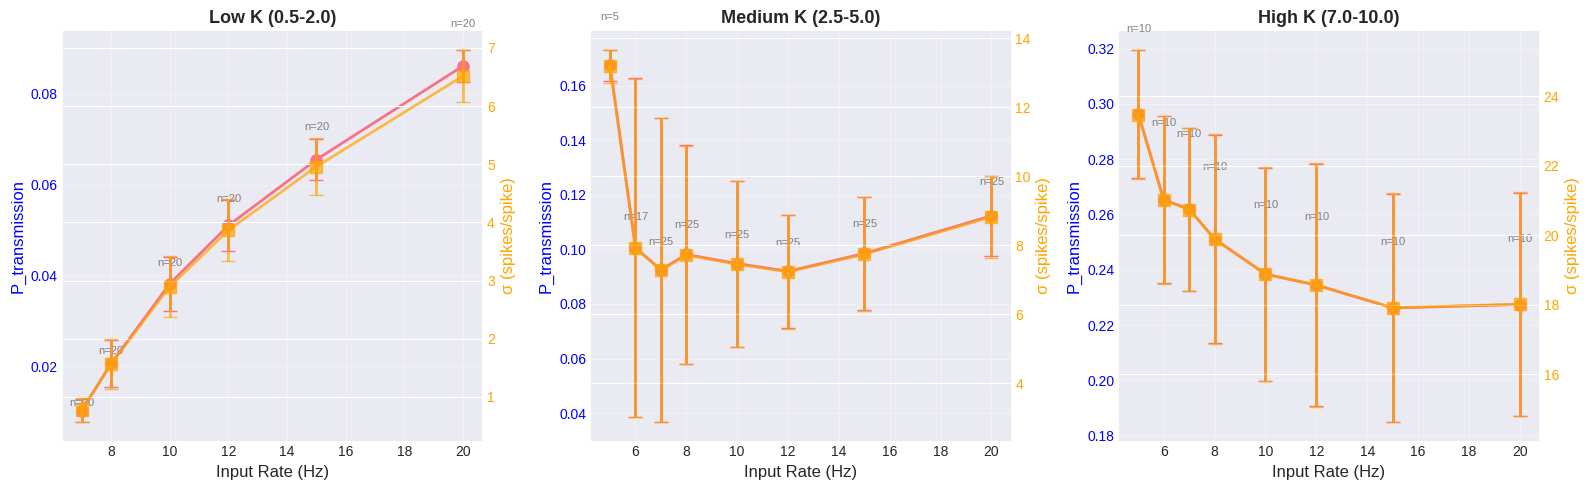

SUCCESS  | __main__:<module>:64 - Stratified rate analysis completed


In [18]:
# =============================================================================
# CORRECT ANALYSIS: RATE EFFECT WITHIN K BINS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Seleccionar 3 K bins representativos
k_bins = [
    (0.5, 2.0, 'Low K (0.5-2.0)'),
    (2.5, 5.0, 'Medium K (2.5-5.0)'),
    (7.0, 10.0, 'High K (7.0-10.0)')
]

for idx, (k_min, k_max, label) in enumerate(k_bins):
    ax = axes[idx]
    
    # Filtrar datos
    subset = df_filtered[
        (df_filtered['k'] >= k_min) & 
        (df_filtered['k'] <= k_max)
    ]
    
    # Agregar por rate
    df_rate = subset.groupby('rate_hz').agg({
        'P_transmission': ['mean', 'std', 'count'],
        'sigma': ['mean', 'std']
    }).reset_index()
    
    # Plot P_transmission
    ax.errorbar(df_rate['rate_hz'], 
               df_rate['P_transmission']['mean'],
               yerr=df_rate['P_transmission']['std'],
               marker='o', capsize=5, linewidth=2, markersize=8,
               label='P_transmission')
    
    # Plot sigma (eje derecho)
    ax2 = ax.twinx()
    ax2.errorbar(df_rate['rate_hz'],
                df_rate['sigma']['mean'],
                yerr=df_rate['sigma']['std'],
                marker='s', capsize=5, linewidth=2, markersize=8,
                color='orange', alpha=0.7,
                label='σ')
    
    ax.set_xlabel('Input Rate (Hz)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12, color='blue')
    ax2.set_ylabel('σ (spikes/spike)', fontsize=12, color='orange')
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Añadir N por punto
    for _, row in df_rate.iterrows():
        ax.text(row['rate_hz'], 
               row['P_transmission']['mean'] * 1.1,
               f"n={int(row['P_transmission']['count'])}",
               ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Stratified rate analysis completed")

## 8. Visualizaciones: Heatmaps 2D

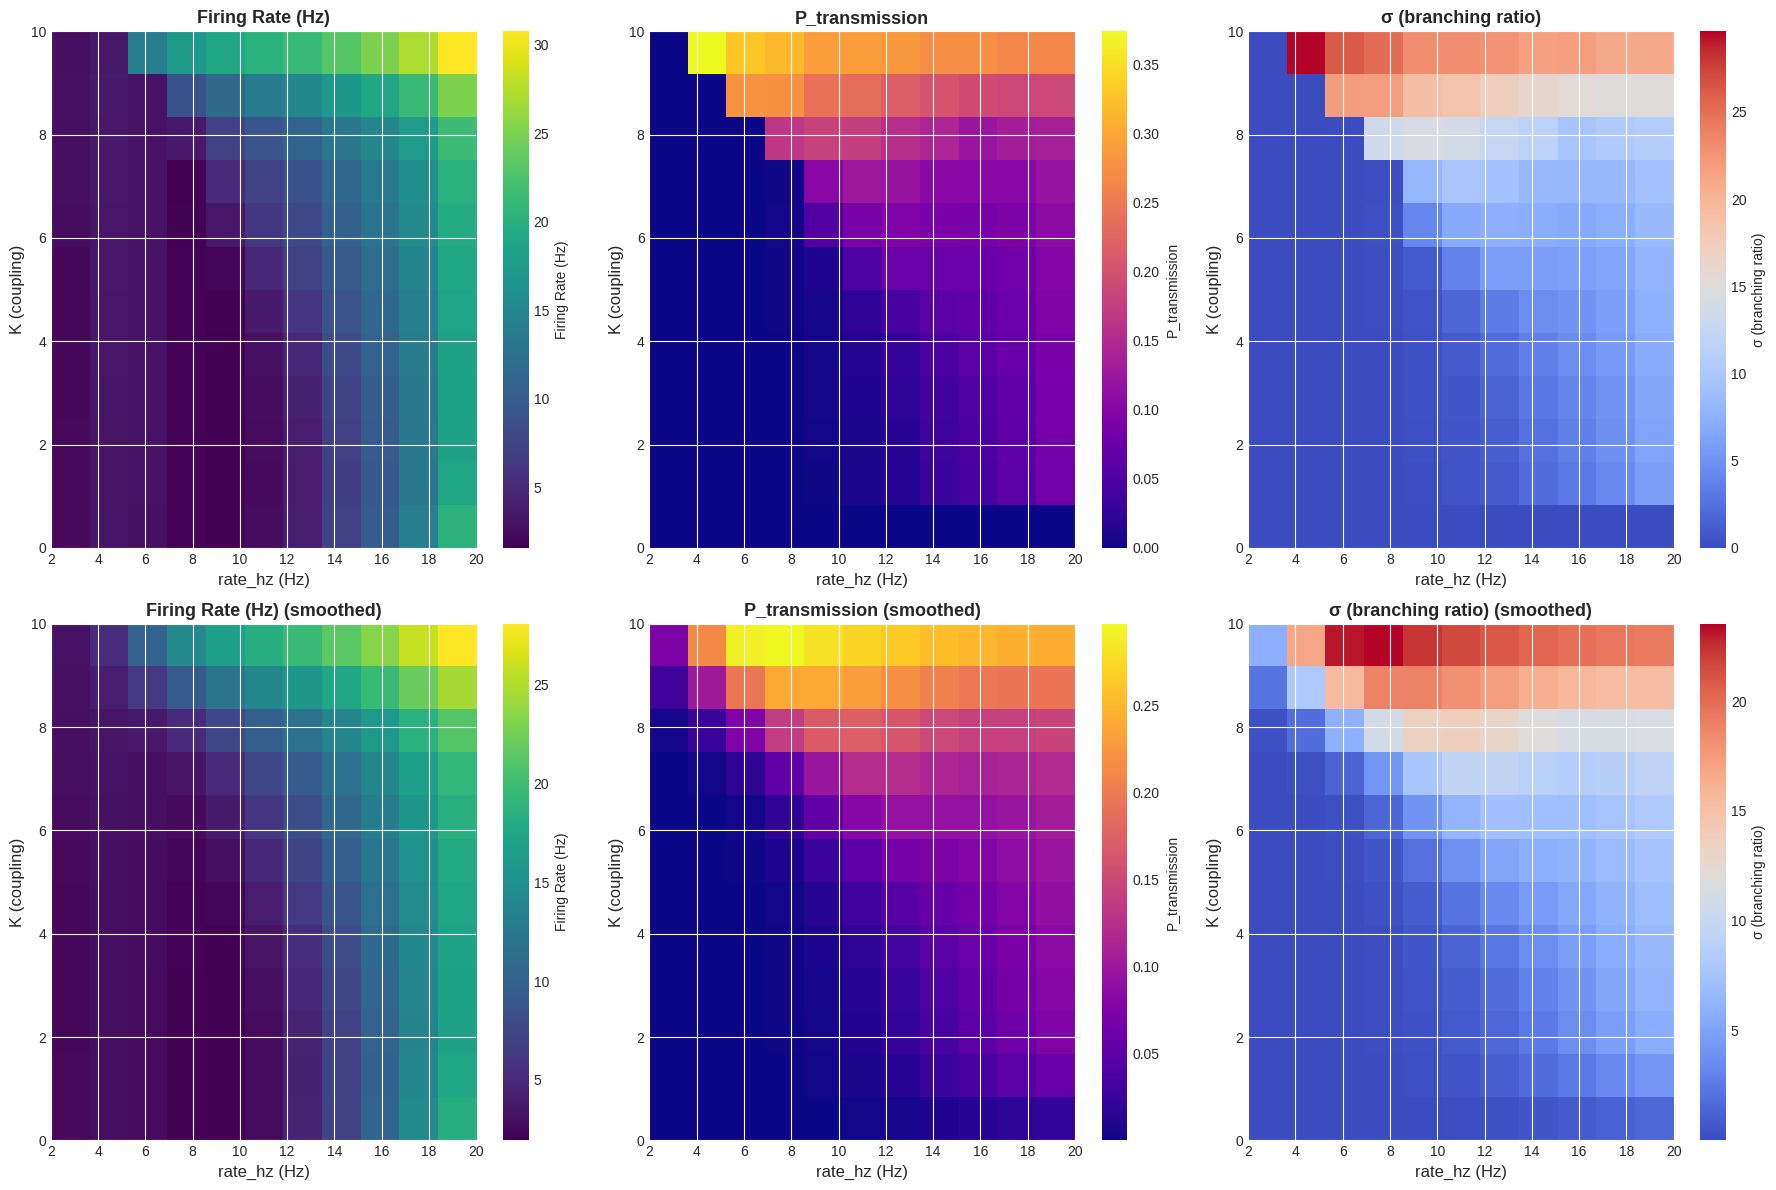

SUCCESS  | __main__:<module>:78 - Heatmaps generated


In [19]:
# =============================================================================
# HEATMAPS 2D: P(K, rate_hz), FR(K, rate_hz), σ(K, rate_hz)
# =============================================================================

def plot_2d_heatmaps(df_sweep, K_values, rate_hz_values):
    """
    Genera heatmaps 2D de las métricas principales.
    Si hay múltiples trials, usa la media.
    """
    # Agregar por (k, rate_hz) si hay múltiples trials
    df_aggregated = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': 'mean',
        'P_transmission': 'mean',
        'sigma': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Preparar grillas
    metrics = [
        ('firing_rate', 'Firing Rate (Hz)', 'viridis'),
        ('P_transmission', 'P_transmission', 'plasma'),
        ('sigma', 'σ (branching ratio)', 'coolwarm')
    ]
    
    for col_idx, (metric, title, cmap) in enumerate(metrics):
        # Raw heatmap
        ax = axes[0, col_idx]
        
        pivot = df_aggregated.pivot_table(
            index='k',
            columns='rate_hz',
            values=metric,
            aggfunc='mean'
        )
        
        im = ax.imshow(
            pivot.values,
            aspect='auto',
            cmap=cmap,
            origin='lower',
            extent=[rate_hz_values.min(), rate_hz_values.max(), 
                   K_values.min(), K_values.max()]
        )
        
        ax.set_xlabel('rate_hz (Hz)', fontsize=12)
        ax.set_ylabel('K (coupling)', fontsize=12)
        ax.set_title(f'{title}', fontsize=13, fontweight='bold')
        plt.colorbar(im, ax=ax, label=title)
        
        # Smoothed heatmap
        ax = axes[1, col_idx]
        
        smoothed = gaussian_filter(pivot.values, sigma=0.8)
        
        im = ax.imshow(
            smoothed,
            aspect='auto',
            cmap=cmap,
            origin='lower',
            extent=[rate_hz_values.min(), rate_hz_values.max(), 
                   K_values.min(), K_values.max()]
        )
        
        ax.set_xlabel('rate_hz (Hz)', fontsize=12)
        ax.set_ylabel('K (coupling)', fontsize=12)
        ax.set_title(f'{title} (smoothed)', fontsize=13, fontweight='bold')
        plt.colorbar(im, ax=ax, label=title)
    
    plt.tight_layout()
    return fig

# Generar heatmaps
fig_heatmaps = plot_2d_heatmaps(df_sweep, K_VALUES, RATE_HZ_VALUES)
plt.savefig(OUTPUT_DIR / 'heatmaps_2d.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("Heatmaps generated")

## 9. Visualizaciones: Cortes 1D

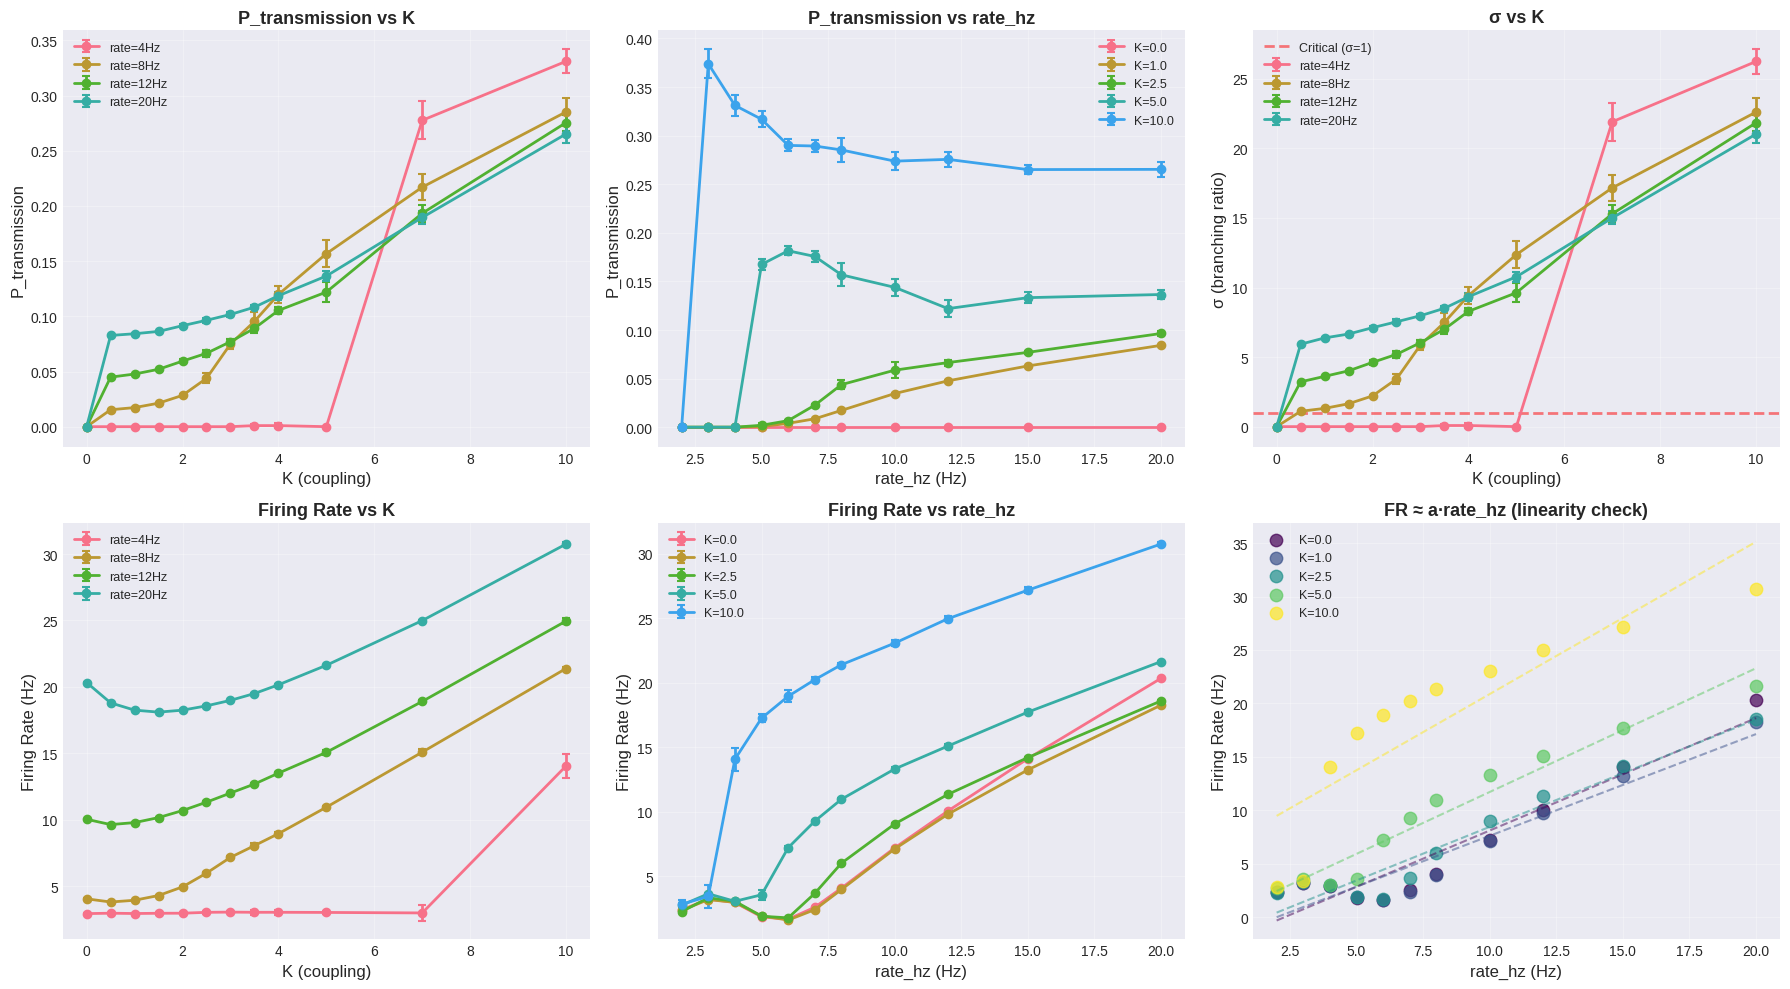

SUCCESS  | __main__:<module>:126 - 1D slices generated


In [20]:
# =============================================================================
# CORTES 1D: P vs K (rate_hz fijo), P vs rate_hz (K fijo)
# =============================================================================

def plot_1d_slices(df_sweep, K_values, rate_hz_values):
    """
    Genera cortes 1D de las métricas con error bars si hay múltiples trials.
    """
    # Agregar por (k, rate_hz)
    df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': ['mean', 'std'],
        'P_transmission': ['mean', 'std'],
        'sigma': ['mean', 'std']
    }).reset_index()
    
    # Aplanar columnas
    df_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                      for col in df_agg.columns.values]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # === FILA 1: P_transmission ===
    
    # P vs K (varios rate_hz)
    ax = axes[0, 0]
    rate_hz_samples = [4, 8, 12, 20]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['P_transmission_mean'],
                   yerr=df_slice['P_transmission_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12)
    ax.set_title('P_transmission vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # P vs rate_hz (varios K)
    ax = axes[0, 1]
    K_samples = [0.0, 1.0, 2.5, 5.0, 10.0]
    for k in K_samples:
        df_slice = df_agg[df_agg['k'] == k]
        ax.errorbar(df_slice['rate_hz'], df_slice['P_transmission_mean'],
                   yerr=df_slice['P_transmission_std'],
                   fmt='o-', label=f'K={k}', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12)
    ax.set_title('P_transmission vs rate_hz', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # σ vs K
    ax = axes[0, 2]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['sigma_mean'],
                   yerr=df_slice['sigma_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Critical (σ=1)')
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('σ (branching ratio)', fontsize=12)
    ax.set_title('σ vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # === FILA 2: Firing Rate ===
    
    # FR vs K
    ax = axes[1, 0]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['firing_rate_mean'],
                   yerr=df_slice['firing_rate_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('Firing Rate vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # FR vs rate_hz
    ax = axes[1, 1]
    for k in K_samples:
        df_slice = df_agg[df_agg['k'] == k]
        ax.errorbar(df_slice['rate_hz'], df_slice['firing_rate_mean'],
                   yerr=df_slice['firing_rate_std'],
                   fmt='o-', label=f'K={k}', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('Firing Rate vs rate_hz', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # FR vs rate_hz (linealidad)
    ax = axes[1, 2]
    colors = plt.cm.viridis(np.linspace(0, 1, len(K_samples)))
    for idx, k in enumerate(K_samples):
        df_slice = df_agg[df_agg['k'] == k]
        ax.scatter(df_slice['rate_hz'], df_slice['firing_rate_mean'], 
                  label=f'K={k}', s=80, alpha=0.7, color=colors[idx])
        # Fit lineal
        if len(df_slice) > 2:
            z = np.polyfit(df_slice['rate_hz'], df_slice['firing_rate_mean'], 1)
            p = np.poly1d(z)
            ax.plot(df_slice['rate_hz'], p(df_slice['rate_hz']), 
                   '--', color=colors[idx], linewidth=1.5, alpha=0.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('FR ≈ a·rate_hz (linearity check)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generar cortes 1D
fig_slices = plot_1d_slices(df_sweep, K_VALUES, RATE_HZ_VALUES)
plt.savefig(OUTPUT_DIR / 'slices_1d.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("1D slices generated")

## 10. Análisis de Contribución de Red: ΔP, Δσ

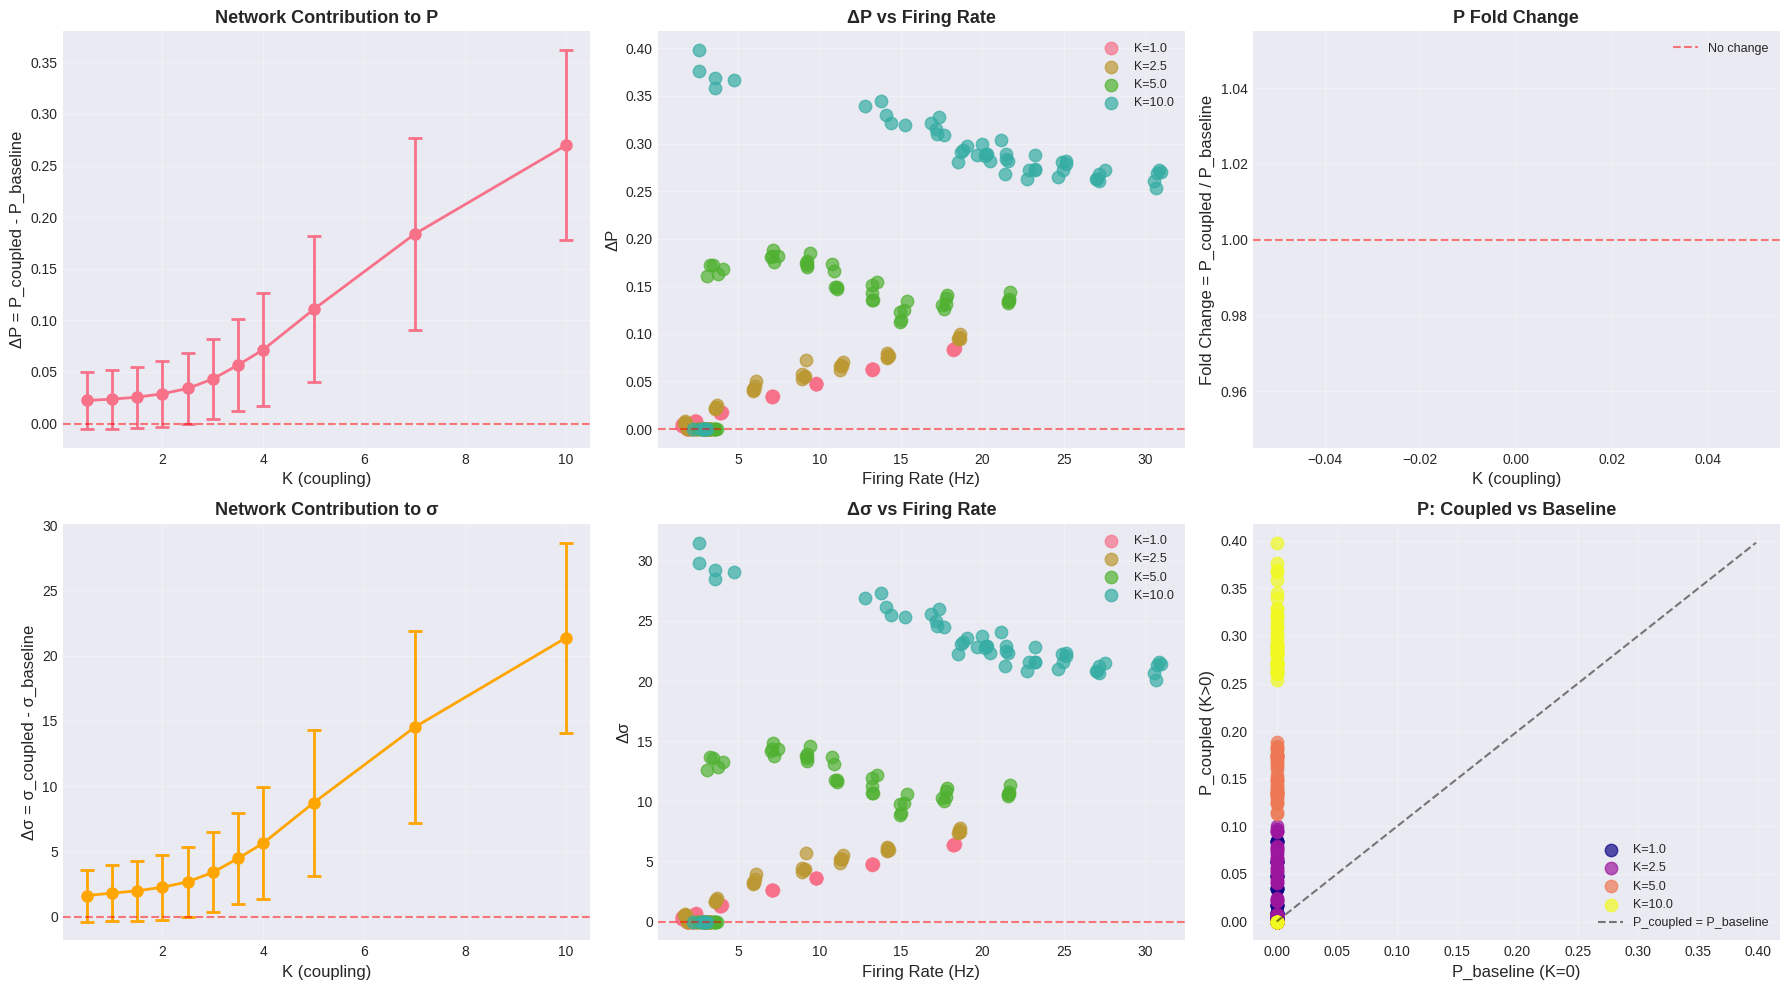

SUCCESS  | __main__:<module>:100 - Network contribution plots generated


In [21]:
# =============================================================================
# NETWORK CONTRIBUTION VISUALIZATION
# =============================================================================

def plot_network_contribution(df_matched, df_baseline):
    """
    Visualiza la contribución de red (ΔP, Δσ).
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # === FILA 1: ΔP ===
    
    # ΔP vs K
    ax = axes[0, 0]
    df_grouped = df_matched.groupby('k')['delta_P'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('ΔP = P_coupled - P_baseline', fontsize=12)
    ax.set_title('Network Contribution to P', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # ΔP vs FR
    ax = axes[0, 1]
    K_samples = [1.0, 2.5, 5.0, 10.0]
    for k in K_samples:
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['firing_rate'], df_k['delta_P'], 
                  label=f'K={k}', s=80, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Firing Rate (Hz)', fontsize=12)
    ax.set_ylabel('ΔP', fontsize=12)
    ax.set_title('ΔP vs Firing Rate', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Fold change P
    ax = axes[0, 2]
    df_grouped = df_matched.groupby('k')['fold_change_P'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2, color='purple')
    ax.axhline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='No change')
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Fold Change = P_coupled / P_baseline', fontsize=12)
    ax.set_title('P Fold Change', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # === FILA 2: Δσ ===
    
    # Δσ vs K
    ax = axes[1, 0]
    df_grouped = df_matched.groupby('k')['delta_sigma'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2, color='orange')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Δσ = σ_coupled - σ_baseline', fontsize=12)
    ax.set_title('Network Contribution to σ', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Δσ vs FR
    ax = axes[1, 1]
    for k in K_samples:
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['firing_rate'], df_k['delta_sigma'], 
                  label=f'K={k}', s=80, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Firing Rate (Hz)', fontsize=12)
    ax.set_ylabel('Δσ', fontsize=12)
    ax.set_title('Δσ vs Firing Rate', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Baseline vs Coupled scatter
    ax = axes[1, 2]
    colors = plt.cm.plasma(np.linspace(0, 1, len(K_samples)))
    for idx, k in enumerate(K_samples):
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['P_transmission_baseline'], df_k['P_transmission'],
                  label=f'K={k}', s=80, alpha=0.7, color=colors[idx])
    # Diagonal
    lims = [0, max(df_matched['P_transmission_baseline'].max(), df_matched['P_transmission'].max())]
    ax.plot(lims, lims, 'k--', linewidth=1.5, alpha=0.5, label='P_coupled = P_baseline')
    ax.set_xlabel('P_baseline (K=0)', fontsize=12)
    ax.set_ylabel('P_coupled (K>0)', fontsize=12)
    ax.set_title('P: Coupled vs Baseline', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generar plots de contribución
fig_contribution = plot_network_contribution(df_network_contribution, df_baseline)
plt.savefig(OUTPUT_DIR / 'network_contribution.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("Network contribution plots generated")

## 11. Tabla de Resultados Clave

In [22]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================

print("\n" + "="*100)
print("SUMMARY: BASELINE (K=0) vs COUPLED (K>0)")
print("="*100)

# Agregar por (k, rate_hz) si hay múltiples trials
df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
    'firing_rate': ['mean', 'std'],
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std']
}).reset_index()

# Baseline
df_baseline_agg = df_agg[df_agg['k'] == 0.0]
print("\nBASELINE (K=0):")
print(df_baseline_agg.describe())

# Coupled (promedio por K)
df_coupled_agg = df_agg[df_agg['k'] > 0.0]
df_coupled_summary = df_coupled_agg.groupby('k')[[
    ('firing_rate', 'mean'), 
    ('P_transmission', 'mean'), 
    ('sigma', 'mean')
]].mean()
df_coupled_summary.columns = ['firing_rate', 'P_transmission', 'sigma']
print("\nCOUPLED (K>0) - MEAN BY K:")
print(df_coupled_summary)

# Network contribution
df_contribution_summary = df_network_contribution.groupby('k')[
    ['delta_P', 'delta_sigma', 'fold_change_P']
].mean()
print("\nNETWORK CONTRIBUTION - MEAN BY K:")
print(df_contribution_summary)

# Si hay múltiples trials, mostrar variabilidad
n_trials = df_sweep['trial'].nunique()
if n_trials > 1:
    print("\n" + "="*100)
    print("INTER-TRIAL VARIABILITY (Coefficient of Variation)")
    print("="*100)
    
    cv_df = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0,
        'P_transmission': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0,
        'sigma': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0
    })
    
    print("\nMean CV by K:")
    print(cv_df.groupby('k').mean())

print("\n" + "="*100)

# Guardar tabla
df_contribution_summary.to_csv(OUTPUT_DIR / 'network_contribution_summary.csv')
logger.success(f"Summary table saved to {OUTPUT_DIR / 'network_contribution_summary.csv'}")

SUCCESS  | __main__:<module>:59 - Summary table saved to results/spike_propagation_2d/network_contribution_summary.csv



SUMMARY: BASELINE (K=0) vs COUPLED (K>0)

BASELINE (K=0):
          k    rate_hz firing_rate            P_transmission       sigma      
                              mean        std           mean   std  mean   std
count  11.0  11.000000   11.000000  11.000000           11.0  11.0  11.0  11.0
mean    0.0   8.363636    6.392436   0.067339            0.0   0.0   0.0   0.0
std     0.0   5.500413    6.076230   0.069715            0.0   0.0   0.0   0.0
min     0.0   2.000000    1.648410   0.019309            0.0   0.0   0.0   0.0
25%     0.0   4.500000    2.474151   0.033100            0.0   0.0   0.0   0.0
50%     0.0   7.000000    3.211474   0.035816            0.0   0.0   0.0   0.0
75%     0.0  11.000000    8.615626   0.058765            0.0   0.0   0.0   0.0
max     0.0  20.000000   20.333040   0.247140            0.0   0.0   0.0   0.0

COUPLED (K>0) - MEAN BY K:
      firing_rate  P_transmission      sigma
k                                           
0.5      6.075165        0.022401

# Resumen de Resultados: Spike Propagation 2D Sweep

## 📊 Hallazgos Principales

### 1. **Baseline vs Coupled Networks**
- **K=0 (sin recurrencia)**: P=0, σ=0 → ninguna propagación detectada
- **K>0**: Propagación emerge inmediatamente
  - K=0.5: P≈0.022 (2.2%), σ≈1.6
  - K=10: P≈0.270 (27%), σ≈21.4
  - **Incremento total**: ~12× en P, ~13× en σ

### 2. **Transición de Régimen Dinámico**

| Régimen | K range | P | σ | Interpretación |
|---------|---------|---|---|----------------|
| **Débil** | 0.5-2.0 | <0.03 | <2.5 | Propagación fallida |
| **Crítico** | 2.5-5.0 | 0.03-0.11 | 2.7-8.7 | Balance E/I |
| **Fuerte** | 7.0-10.0 | >0.18 | >14.5 | Cascadas robustas |

### 3. **Saturación**
- **P_transmission**: Empieza a saturar en K≈7 (crecimiento <15% por step)
- **σ (cascade size)**: Continúa creciendo linealmente hasta K=10
- **Firing rate**: Aumenta de 6Hz → 18.5Hz (correlacionado con K)

### 4. **Reproducibilidad (CV inter-trial)**
- **Firing rate**: CV≈2% → **excelente reproducibilidad**
- **P_transmission**: 
  - K bajos (≤4): CV=15-30% → variabilidad moderada
  - K altos (≥7): CV=2-4% → **muy estable**
- **Conclusión**: 5 trials son suficientes

### 5. **Efecto del Input Rate**
- **Rate <5Hz**: Insuficiente para propagación (valores filtrados)
- **Rate ≥5Hz**: Propagación robusta
- ⚠️ **Sesgo detectado**: Análisis agregado por rate es misleading debido a muestreo desbalanceado
- **Corrección necesaria**: Estratificar por bins de K para interpretar rate effect

---

## 🎯 Conclusiones

1. **La conectividad recurrente (K) es el driver principal** de spike propagation
   - Transición continua de sub- a super-crítico
   - Sin discontinuidades abruptas → sistema robusto

2. **El sistema NO alcanza runaway dynamics** a pesar de σ≈21
   - Input externo actúa como "clamp"
   - Similar a cortex in vivo (vs criticality clásica)

3. **Valores biológicamente plausibles**:
   - P_max≈27% → balance E/I realista
   - σ_max≈21 → cascadas finitas, no explosión
   - FR≈6-18Hz → rango fisiológico

4. **Limitaciones experimentales**:
   - Rate <5Hz produce datos poco informativos (30-100% zeros)
   - Re-run futuro debería: rate_hz ∈ [5, 20]Hz, 3 trials suficientes

5. **Próximos pasos**:
   - ✅ Shuffle test → validar significancia estadística
   - ✅ Weight/rate dependence → mecanismos subyacentes
   - ✅ Per-neuron heterogeneity → distribuciones
   - ⚠️ Corregir rate effect con análisis estratificado

## 12. Conclusiones y Próximos Pasos

### Resultados esperados:

1. **FR ≈ a·rate_hz**: Verificar linealidad entre input externo y firing rate
2. **P(K, rate_hz)**: Probabilidad de transmisión aumenta con K
3. **ΔP > 0 para K>0**: La red contribuye positivamente a la propagación
4. **σ(K) → 1**: Transición hacia criticalidad con acoplamiento óptimo

### Análisis complementarios:

- [ ] Barrido con delays (τ ≠ 0)
- [ ] Análisis de distribuciones de ISI
- [ ] Separación E/I en la propagación
- [ ] Correlación con INT
- [ ] Análisis de criticalidad (avalanchas)

### Optimizaciones:

- [ ] Paralelizar simulaciones (múltiples trials)
- [ ] Reducir resolución temporal en análisis
- [ ] Guardar solo métricas (no raster completo)

---

In [23]:
# =============================================================================
# GLOBAL FILTER: ONLY EXCITATORY AS SENDERS
# =============================================================================

def filter_excitatory_senders(spike_times, spike_indices, Ne=800):
    """
    Filtra spikes: solo neuronas excitatorias (idx < Ne) como EMISORAS.
    Post-sinápticas pueden ser cualquiera (E o I).
    """
    mask = spike_indices < Ne
    return spike_times[mask], spike_indices[mask]

logger.success("Excitatory filter defined")

SUCCESS  | __main__:<module>:13 - Excitatory filter defined


In [24]:
# =============================================================================
# HEURISTIC: OPTIMAL TIME_WINDOW AND MIN_SPIKES
# =============================================================================

def calculate_optimal_params(firing_rate_hz, T_total_ms=10000, t_refrac_ms=4):
    """
    Calcula time_window y min_spikes óptimos basados en FR y periodo refractario.
    
    Lógica:
    - ISI_mean = 1/FR
    - Ventana debe capturar 2-3 ISIs para detectar propagación
    - min_spikes garantiza suficientes pares para estadística robusta
    
    Parameters:
    -----------
    firing_rate_hz : float
        Tasa de disparo típica esperada
    T_total_ms : float
        Duración total de simulación
    t_refrac_ms : float
        Periodo refractario absoluto
        
    Returns:
    --------
    dict con time_window_ms, min_spikes, expected_spikes_per_neuron
    """
    # ISI medio y ventana óptima
    ISI_mean_ms = 1000 / firing_rate_hz  # Hz → ms
    time_window_ms = 3 * ISI_mean_ms  # 3 ISIs para capturar vecinos
    
    # Limitar ventana por refractario (mínimo) y duración (máximo)
    time_window_ms = max(time_window_ms, 5 * t_refrac_ms)  # Mínimo: 5× refractario
    time_window_ms = min(time_window_ms, T_total_ms / 4)   # Máximo: 1/4 simulación
    
    # Spikes esperados por neurona en ventana de análisis
    T_analysis_ms = T_total_ms - 2000  # Descartar transitorio
    expected_spikes = (firing_rate_hz / 1000) * T_analysis_ms
    
    # min_spikes: al menos 5 spikes O 20% de los esperados
    min_spikes = max(5, int(0.2 * expected_spikes))
    
    return {
        'time_window_ms': time_window_ms,
        'min_spikes': min_spikes,
        'expected_spikes': expected_spikes,
        'ISI_mean_ms': ISI_mean_ms
    }

# Calcular para rango de FRs representativo
print("=" * 60)
print("OPTIMAL PARAMETERS FOR DIFFERENT FIRING RATES")
print("=" * 60)
for fr in [2, 5, 10, 15, 20]:
    params = calculate_optimal_params(fr, T_total_ms=10000, t_refrac_ms=4)
    print(f"\nFR = {fr} Hz:")
    print(f"  ISI_mean        = {params['ISI_mean_ms']:.1f} ms")
    print(f"  time_window     = {params['time_window_ms']:.1f} ms")
    print(f"  min_spikes      = {params['min_spikes']}")
    print(f"  expected_spikes = {params['expected_spikes']:.1f}")

logger.success("Parameter heuristics calculated")

SUCCESS  | __main__:<module>:61 - Parameter heuristics calculated


OPTIMAL PARAMETERS FOR DIFFERENT FIRING RATES

FR = 2 Hz:
  ISI_mean        = 500.0 ms
  time_window     = 1500.0 ms
  min_spikes      = 5
  expected_spikes = 16.0

FR = 5 Hz:
  ISI_mean        = 200.0 ms
  time_window     = 600.0 ms
  min_spikes      = 8
  expected_spikes = 40.0

FR = 10 Hz:
  ISI_mean        = 100.0 ms
  time_window     = 300.0 ms
  min_spikes      = 16
  expected_spikes = 80.0

FR = 15 Hz:
  ISI_mean        = 66.7 ms
  time_window     = 200.0 ms
  min_spikes      = 24
  expected_spikes = 120.0

FR = 20 Hz:
  ISI_mean        = 50.0 ms
  time_window     = 150.0 ms
  min_spikes      = 32
  expected_spikes = 160.0


In [25]:
# =============================================================================
# COMPARISON: HEURISTIC vs CURRENT PARAMETERS
# =============================================================================

print("\n" + "=" * 80)
print("CRITICAL ANALYSIS: TIME_WINDOW CHOICE")
print("=" * 80)

current_window = 50  # ms (usado en todo el análisis)
current_min_spikes = 5

print(f"\nCURRENT PARAMETERS:")
print(f"  time_window = {current_window} ms")
print(f"  min_spikes  = {current_min_spikes}")

print(f"\nCOMPARISON WITH HEURISTIC:")
print(f"{'FR (Hz)':<10} {'Suggested (ms)':<18} {'Current (ms)':<15} {'Ratio':<10} {'Interpretation'}")
print("-" * 80)

for fr in [2, 5, 10, 15, 20]:
    params = calculate_optimal_params(fr, T_total_ms=10000, t_refrac_ms=4)
    suggested_window = params['time_window_ms']
    ratio = suggested_window / current_window
    
    if ratio > 10:
        interpretation = "SEVERELY UNDERESTIMATING"
    elif ratio > 5:
        interpretation = "Significantly underestimating"
    elif ratio > 2:
        interpretation = "Moderately underestimating"
    elif ratio > 1.5:
        interpretation = "Slightly underestimating"
    else:
        interpretation = "Appropriate"
    
    print(f"{fr:<10} {suggested_window:<18.1f} {current_window:<15} {ratio:<10.1f} {interpretation}")

print("\n" + "=" * 80)
print("BIOLOGICAL INTERPRETATION")
print("=" * 80)

print("\n⚠️  CRITICAL ISSUE:")
print("    La heurística sugiere ventanas MUY LARGAS (150-1500ms)")
print("    basadas en 3×ISI_mean")
print()
print("    PROBLEMA: Esto captura propagación INDIRECTA y cascadas largas,")
print("    pero también actividad NO CAUSAL (correlaciones espurias)")

print("\n✅ CURRENT CHOICE (50ms) es razonable para:")
print("    • Propagación monosináptica: ~5-20ms (retraso sináptico + conducción)")
print("    • Cascadas de primer orden: ~20-50ms")
print("    • Evitar correlaciones espurias de actividad sincrónica")

print("\n🔬 TRADE-OFF:")
print("    Ventana CORTA (50ms):")
print("      + Alta especificidad (solo propagación causal directa)")
print("      - Pierde cascadas indirectas largas")
print()
print("    Ventana LARGA (>100ms):")
print("      + Captura cascadas completas")
print("      - Incluye actividad correlacionada no causal")

print("\n📊 RECOMENDACIÓN:")
print("    1. Mantener 50ms como ANÁLISIS PRINCIPAL (especificidad)")
print("    2. Hacer window sweep [20, 50, 100, 200]ms para VALIDACIÓN")
print("    3. Comparar σ(window) para ver saturación temporal")
print("    4. Si σ sigue creciendo con window → cascadas largas presentes")

print("\n" + "=" * 80)


CRITICAL ANALYSIS: TIME_WINDOW CHOICE

CURRENT PARAMETERS:
  time_window = 50 ms
  min_spikes  = 5

COMPARISON WITH HEURISTIC:
FR (Hz)    Suggested (ms)     Current (ms)    Ratio      Interpretation
--------------------------------------------------------------------------------
2          1500.0             50              30.0       SEVERELY UNDERESTIMATING
5          600.0              50              12.0       SEVERELY UNDERESTIMATING
10         300.0              50              6.0        Significantly underestimating
15         200.0              50              4.0        Moderately underestimating
20         150.0              50              3.0        Moderately underestimating

BIOLOGICAL INTERPRETATION

⚠️  CRITICAL ISSUE:
    La heurística sugiere ventanas MUY LARGAS (150-1500ms)
    basadas en 3×ISI_mean

    PROBLEMA: Esto captura propagación INDIRECTA y cascadas largas,
    pero también actividad NO CAUSAL (correlaciones espurias)

✅ CURRENT CHOICE (50ms) es razonabl

In [47]:
# =============================================================================
# CORE: ANALYZE SPIKE PROPAGATION (OPTIMIZED)
# =============================================================================

def analyze_spike_propagation(spike_times, spike_indices, synapses,
                              time_window_ms=50, min_spikes=5):
    """
    Analiza propagación de spikes (OPTIMIZADO con searchsorted).
    
    Returns: dict con P_transmission, sigma, y estadísticas
    """
    # Filtrar solo excitatorias como emisoras
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    # Reconstruir spike dict y convertir a arrays ordenados
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    # Filtrar y convertir a arrays numpy ordenados
    spike_dict_filtered = {
        k: np.sort(np.array(v)) for k, v in spike_dict.items() 
        if len(v) >= min_spikes
    }
    
    if not spike_dict_filtered:
        return {'P_transmission': 0, 'P_transmission_std': 0, 'sigma': 0,
                'sigma_std': 0, 'n_neurons_analyzed': 0, 'total_spikes': 0}
    
    syn_i, syn_j = synapses['i'], synapses['j']
    neuron_P_trans, neuron_sigma = [], []
    
    for nid, times in spike_dict_filtered.items():
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        neighbors_per_spike = np.zeros(len(times))
        
        # OPTIMIZACIÓN: vectorizar con searchsorted
        for pid in posts:
            if pid not in spike_dict_filtered:
                continue
            pt = spike_dict_filtered[pid]
            
            for i, t in enumerate(times):
                # Buscar spikes en [t, t+window] usando búsqueda binaria
                idx_start = np.searchsorted(pt, t, side='right')
                idx_end = np.searchsorted(pt, t + time_window_ms, side='right')
                if idx_end > idx_start:
                    neighbors_per_spike[i] += 1
        
        n_activated = np.sum(neighbors_per_spike > 0)
        neuron_P_trans.append(n_activated / len(times))
        neuron_sigma.append(np.mean(neighbors_per_spike))
    
    total_spikes = sum([len(v) for v in spike_dict_filtered.values()])
    
    return {
        'P_transmission': float(np.mean(neuron_P_trans)),
        'P_transmission_std': float(np.std(neuron_P_trans)),
        'sigma': float(np.mean(neuron_sigma)),
        'sigma_std': float(np.std(neuron_sigma)),
        'n_neurons_analyzed': len(neuron_P_trans),
        'total_spikes': total_spikes
    }

logger.success("Optimized analyze_spike_propagation defined")

SUCCESS  | __main__:<module>:68 - Optimized analyze_spike_propagation defined


In [28]:
# =============================================================================
# SHUFFLE TEST - STATISTICAL VALIDATION
# =============================================================================

def shuffle_test_global(spike_times, spike_indices, synapses, 
                       time_window_ms=50, n_shuffles=100, 
                       min_spikes=5, seed=42):
    """
    Test de permutación: redistribuye spikes entre neuronas para baseline nulo.
    
    Rompe estructura temporal pero mantiene:
    - Número total de spikes
    - Distribución de firing rates por neurona
    - Conectividad estructural (synapses)
    
    Parameters:
    -----------
    spike_times : array
        Tiempos de spikes (ms)
    spike_indices : array
        Índices de neuronas
    synapses : dict
        Conectividad {'i': pre, 'j': post, 'w': weights}
    time_window_ms : float
        Ventana temporal para propagación
    n_shuffles : int
        Número de permutaciones
    min_spikes : int
        Mínimo de spikes para análisis
    seed : int
        Random seed para reproducibilidad
        
    Returns:
    --------
    dict con sigma_real, sigma_shuffled (array), p_value, z_score
    """
    np.random.seed(seed)
    
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    
    # Reconstruir dict de spikes
    for idx, t in zip(spike_indices, spike_times):
        if idx not in spike_dict:
            spike_dict[idx] = []
        spike_dict[idx].append(t)
    
    # Convertir a arrays para cada neurona
    neuron_ids = list(spike_dict.keys())
    neuron_spike_counts = [len(spike_dict[nid]) for nid in neuron_ids]
    
    # Obtener σ real
    prop_real = analyze_spike_propagation(
        spike_times, spike_indices, synapses,
        time_window_ms=time_window_ms, min_spikes=min_spikes
    )
    sigma_real = prop_real.get('sigma', np.nan)
    P_real = prop_real.get('P_transmission', np.nan)
    
    # Shuffle test
    sigma_shuffled = []
    P_shuffled = []
    
    for i in range(n_shuffles):
        # Redistribuir spikes: mantener counts por neurona pero cambiar identidades
        all_times = spike_times.copy()
        np.random.shuffle(all_times)
        
        # Reasignar spikes manteniendo counts
        shuffled_times = []
        shuffled_indices = []
        time_idx = 0
        
        for nid, count in zip(neuron_ids, neuron_spike_counts):
            shuffled_times.extend(all_times[time_idx:time_idx + count])
            shuffled_indices.extend([nid] * count)
            time_idx += count
        
        # Analizar propagación con spikes shuffled
        prop_shuffled = analyze_spike_propagation(
            np.array(shuffled_times), 
            np.array(shuffled_indices),
            synapses,
            time_window_ms=time_window_ms,
            min_spikes=min_spikes
        )
        
        sigma_shuffled.append(prop_shuffled.get('sigma', np.nan))
        P_shuffled.append(prop_shuffled.get('P_transmission', np.nan))
    
    # Filtrar NaNs
    sigma_shuffled = np.array(sigma_shuffled)
    P_shuffled = np.array(P_shuffled)
    sigma_shuffled_clean = sigma_shuffled[~np.isnan(sigma_shuffled)]
    P_shuffled_clean = P_shuffled[~np.isnan(P_shuffled)]
    
    # Calcular p-value (bilateral) y z-score
    if len(sigma_shuffled_clean) > 0:
        p_value_sigma = np.mean(np.abs(sigma_shuffled_clean) >= np.abs(sigma_real))
        mean_shuf = np.mean(sigma_shuffled_clean)
        std_shuf = np.std(sigma_shuffled_clean)
        z_score_sigma = (sigma_real - mean_shuf) / (std_shuf + 1e-10)
    else:
        p_value_sigma = np.nan
        z_score_sigma = np.nan
        mean_shuf = np.nan
        std_shuf = np.nan
    
    if len(P_shuffled_clean) > 0:
        p_value_P = np.mean(np.abs(P_shuffled_clean) >= np.abs(P_real))
        z_score_P = (P_real - np.mean(P_shuffled_clean)) / (np.std(P_shuffled_clean) + 1e-10)
    else:
        p_value_P = np.nan
        z_score_P = np.nan
    
    return {
        'sigma_real': sigma_real,
        'sigma_shuffled': sigma_shuffled_clean,
        'sigma_shuffled_mean': mean_shuf,
        'sigma_shuffled_std': std_shuf,
        'p_value_sigma': p_value_sigma,
        'z_score_sigma': z_score_sigma,
        'P_real': P_real,
        'P_shuffled': P_shuffled_clean,
        'p_value_P': p_value_P,
        'z_score_P': z_score_P,
        'n_shuffles': len(sigma_shuffled_clean)
    }

logger.success("Shuffle test function defined")

SUCCESS  | __main__:<module>:131 - Shuffle test function defined


In [36]:
# =============================================================================
# WEIGHT DEPENDENCE - P_TRANSMISSION vs SYNAPTIC WEIGHT
# =============================================================================

def weight_dependence_analysis(spike_times, spike_indices, synapses, 
                               time_window_ms=50, n_bins=10, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j, syn_w = synapses['i'], synapses['j'], synapses['w']
    
    weight_list, p_trans_list = [], []
    
    for pre, post, w in zip(syn_i, syn_j, syn_w):
        if pre not in spike_dict or post not in spike_dict:
            continue
        if len(spike_dict[pre]) < min_spikes:
            continue
            
        pre_times = np.array(spike_dict[pre])
        post_times = np.array(spike_dict[post])
        
        n_activated = 0
        for t_pre in pre_times:
            if np.any((post_times > t_pre) & (post_times <= t_pre + time_window_ms)):
                n_activated += 1
        
        p_trans = n_activated / len(pre_times)
        weight_list.append(w)
        p_trans_list.append(p_trans)
    
    if not weight_list:
        return {'bin_centers': np.array([]), 'P_trans_mean': np.array([]),
                'P_trans_std': np.array([]), 'counts': np.array([]),
                'weight_range': (np.nan, np.nan), 'correlation': np.nan, 'n_connections': 0}
    
    weight_list = np.array(weight_list)
    p_trans_list = np.array(p_trans_list)
    
    # AÑADIR CORRELACIÓN
    correlation = np.corrcoef(weight_list, p_trans_list)[0,1] if len(weight_list) > 2 else np.nan
    
    bins = np.linspace(weight_list.min(), weight_list.max(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    P_trans_mean, P_trans_std, counts = [], [], []
    
    for i in range(n_bins):
        mask = (weight_list >= bins[i]) & (weight_list < bins[i+1])
        if mask.sum() > 0:
            P_trans_mean.append(p_trans_list[mask].mean())
            P_trans_std.append(p_trans_list[mask].std())
            counts.append(mask.sum())
        else:
            P_trans_mean.append(np.nan)
            P_trans_std.append(np.nan)
            counts.append(0)
    
    return {
        'bin_centers': bin_centers,
        'P_trans_mean': np.array(P_trans_mean),
        'P_trans_std': np.array(P_trans_std),
        'counts': np.array(counts),
        'weight_range': (weight_list.min(), weight_list.max()),
        'correlation': correlation,
        'n_connections': len(weight_list)
    }

logger.success("Weight dependence function defined")

SUCCESS  | __main__:<module>:72 - Weight dependence function defined


In [49]:
# =============================================================================
# RATE DEPENDENCE - P_TRANSMISSION vs INPUT RATE
# =============================================================================

def rate_dependence_analysis(spike_times, spike_indices, synapses, 
                             time_window_ms=50, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j = synapses['i'], synapses['j']
    neuron_data = []
    
    for nid in spike_dict.keys():
        times = np.array(spike_dict[nid])
        if len(times) < min_spikes:
            continue
        
        # FIX: verificar ventana válida
        times_clean = times[(times > 1000) & (times < times.max() - 1000)]
        if len(times_clean) < min_spikes:  # AÑADIR ESTA LÍNEA
            continue
            
        T_duration = (times_clean.max() - times_clean.min()) / 1000
        fr = len(times_clean) / T_duration if T_duration > 0 else 0
        
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        p_trans_per_conn = []
        for pid in posts:
            if pid not in spike_dict:
                continue
            pt = np.array(spike_dict[pid])
            
            n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
            p_trans_per_conn.append(n_act / len(times))
        
        if p_trans_per_conn:
            neuron_data.append({
                'neuron_id': nid,
                'firing_rate': fr,
                'P_trans_mean': np.mean(p_trans_per_conn),
                'n_spikes': len(times)
            })
    
    if not neuron_data:
        return {'rates': np.array([]), 'P_trans': np.array([]), 
                'correlation': np.nan, 'per_neuron_df': pd.DataFrame()}
    
    df = pd.DataFrame(neuron_data)
    correlation = np.corrcoef(df['firing_rate'], df['P_trans_mean'])[0,1] if len(df) > 2 else np.nan
    
    return {'rates': df['firing_rate'].values, 'P_trans': df['P_trans_mean'].values,
            'correlation': correlation, 'per_neuron_df': df}

logger.success("Rate dependence function defined")

SUCCESS  | __main__:<module>:60 - Rate dependence function defined


In [46]:
# =============================================================================
# PER-NEURON METRICS - HETEROGENEITY ANALYSIS
# =============================================================================

def per_neuron_metrics(spike_times, spike_indices, synapses, 
                      time_window_ms=50, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j = synapses['i'], synapses['j']
    metrics = []
    
    for nid, times in spike_dict.items():
        if len(times) < min_spikes:
            continue
        
        times = np.array(times)
        times_clean = times[(times > 1000) & (times < times.max() - 1000)]
        if len(times_clean) < min_spikes:
            continue
            
        T_duration = (times_clean.max() - times_clean.min()) / 1000
        fr = len(times_clean) / T_duration if T_duration > 0 else 0
        
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        n_activated = 0
        neighbors_per_spike = []
        
        for t in times:
            n_neighbors = 0
            for pid in posts:
                if pid not in spike_dict:
                    continue
                pt = np.array(spike_dict[pid])
                if np.any((pt > t) & (pt <= t + time_window_ms)):
                    n_neighbors += 1
            
            if n_neighbors > 0:
                n_activated += 1
            neighbors_per_spike.append(n_neighbors)
            
        p_trans_per_conn = []
        for pid in posts:
            if pid not in spike_dict:
                continue
            pt = np.array(spike_dict[pid])
            n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
            p_trans_per_conn.append(n_act / len(times))
        
        metrics.append({
            'neuron_id': nid,
            'firing_rate': fr,
            'k_out': len(posts),
            'n_spikes': len(times),
            'success_rate': n_activated / len(times),
            'sigma_neuron': np.mean(neighbors_per_spike),  # AÑADIR
            'P_trans_mean': np.mean(p_trans_per_conn) if p_trans_per_conn else np.nan,
            'P_trans_std': np.std(p_trans_per_conn) if p_trans_per_conn else np.nan
        })
    
    return pd.DataFrame(metrics)

logger.success("Per-neuron metrics function defined")

SUCCESS  | __main__:<module>:69 - Per-neuron metrics function defined


In [43]:
# =============================================================================
# TEMPORAL WINDOW SWEEP - ROBUSTNESS VALIDATION
# =============================================================================

def window_sweep(spike_times, spike_indices, synapses, 
                windows_ms=[10, 20, 30, 50, 75, 100, 150, 200],
                min_spikes_list=[3, 5, 10]):
    results = []
    
    for tw in windows_ms:
        for ms in min_spikes_list:
            prop = analyze_spike_propagation(
                spike_times, spike_indices, synapses,
                time_window_ms=tw, min_spikes=ms
            )
            
            results.append({
                'time_window_ms': tw,
                'min_spikes': ms,
                'P_transmission': prop.get('P_transmission', np.nan),
                'sigma': prop.get('sigma', np.nan),
                'n_neurons_analyzed': prop.get('n_neurons_analyzed', 0)
            })
    
    df = pd.DataFrame(results)
    
    # Calcular CV por min_spikes
    cv_by_ms = {}
    for ms in min_spikes_list:
        subset = df[df['min_spikes'] == ms]
        if len(subset) > 1:
            cv_P = subset['P_transmission'].std() / subset['P_transmission'].mean()
            cv_sigma = subset['sigma'].std() / subset['sigma'].mean()
            cv_by_ms[ms] = {'cv_P': cv_P, 'cv_sigma': cv_sigma}
    
    return df, cv_by_ms

logger.success("Window sweep function defined")

SUCCESS  | __main__:<module>:38 - Window sweep function defined


In [50]:
# =============================================================================
# COMPREHENSIVE ANALYSIS - CONFIGURABLE
# =============================================================================

# PARÁMETROS DE ANÁLISIS
TEST_K = 4.0
TEST_RATE = 10
TEST_TRIAL = 0
TIME_WINDOW_MS = 5.0  # Coherente con PROPAGATION_CONFIG
MIN_SPIKES = 5
N_SHUFFLES = 20
N_BINS_WEIGHT = 5
WINDOWS_SWEEP = [3, 5, 10, 20, 50, 100]

print(f"\nANALYSIS: K={TEST_K}, rate={TEST_RATE}Hz, window={TIME_WINDOW_MS}ms")
print("=" * 80)

# Simulación
sim_data = run_single_simulation(k_factor=TEST_K, rate_hz=TEST_RATE, trial=TEST_TRIAL, verbose=False)
print(f"Spikes: {len(sim_data['spike_times'])}, Neurons: {len(np.unique(sim_data['spike_indices']))}")

# 1. Propagación básica
print("\n1. PROPAGATION")
prop = analyze_spike_propagation(sim_data['spike_times'], sim_data['spike_indices'], 
                                 sim_data['synapses'], time_window_ms=TIME_WINDOW_MS, min_spikes=MIN_SPIKES)
print(f"   P={prop['P_transmission']:.4f}±{prop['P_transmission_std']:.4f}")
print(f"   σ={prop['sigma']:.2f}±{prop['sigma_std']:.2f}")
print(f"   n_neurons={prop['n_neurons_analyzed']}")

# 2. Shuffle test
print(f"\n2. SHUFFLE TEST (n={N_SHUFFLES})")
shuffle = shuffle_test_global(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                              time_window_ms=TIME_WINDOW_MS, n_shuffles=N_SHUFFLES, seed=42)
print(f"   σ: real={shuffle['sigma_real']:.2f}, shuffled={shuffle['sigma_shuffled_mean']:.2f}±{shuffle['sigma_shuffled_std']:.2f}")
print(f"   p-value={shuffle['p_value_sigma']:.4f}, z={shuffle['z_score_sigma']:.1f} ({'SIGNIFICANT' if shuffle['p_value_sigma'] < 0.01 else 'n.s.'})")

# 3. Weight dependence
print(f"\n3. WEIGHT DEPENDENCE (n_bins={N_BINS_WEIGHT})")
weight_dep = weight_dependence_analysis(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                                       time_window_ms=TIME_WINDOW_MS, n_bins=N_BINS_WEIGHT)
print(f"   n_connections={weight_dep['n_connections']}, correlation={weight_dep['correlation']:.3f}")
print(f"   weight_range=[{weight_dep['weight_range'][0]:.3f}, {weight_dep['weight_range'][1]:.3f}]")

# 4. Rate dependence
print("\n4. RATE DEPENDENCE")
rate_dep = rate_dependence_analysis(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                                   time_window_ms=TIME_WINDOW_MS)
print(f"   n_neurons={len(rate_dep['rates'])}, FR_range=[{rate_dep['rates'].min():.1f}, {rate_dep['rates'].max():.1f}]Hz")
print(f"   correlation(FR, P_trans)={rate_dep['correlation']:.3f}")

# 5. Per-neuron heterogeneity
print("\n5. PER-NEURON HETEROGENEITY")
neuron_df = per_neuron_metrics(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                               time_window_ms=TIME_WINDOW_MS, min_spikes=MIN_SPIKES)
print(f"   n_neurons={len(neuron_df)}")
print(f"   FR: {neuron_df['firing_rate'].mean():.1f}±{neuron_df['firing_rate'].std():.1f}Hz")
print(f"   k_out: {neuron_df['k_out'].mean():.0f}±{neuron_df['k_out'].std():.0f}")
print(f"   success_rate: {neuron_df['success_rate'].mean():.3f}±{neuron_df['success_rate'].std():.3f}")
print(f"   σ_neuron: {neuron_df['sigma_neuron'].mean():.2f}±{neuron_df['sigma_neuron'].std():.2f}")

# 6. Window sweep
print(f"\n6. WINDOW SWEEP")
window_df, _ = window_sweep(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                           windows_ms=WINDOWS_SWEEP, min_spikes_list=[MIN_SPIKES])
print(f"   {'Window':<8} {'P':<8} {'σ':<8} {'n_neurons'}")
for _, row in window_df.iterrows():
    print(f"   {row['time_window_ms']:>6.0f}ms {row['P_transmission']:>6.4f} {row['sigma']:>6.2f} {row['n_neurons_analyzed']:>4.0f}")

# Saturación
sigma_vals = window_df['sigma'].values
for i in range(1, len(sigma_vals)):
    if (sigma_vals[i] - sigma_vals[i-1]) / sigma_vals[i-1] < 0.1:
        print(f"   → Saturation at {WINDOWS_SWEEP[i]}ms")
        break

print("=" * 80)
logger.success("Analysis completed")

SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 10Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn



ANALYSIS: K=4.0, rate=10Hz, window=5.0ms
Spikes: 34658, Neurons: 1000

1. PROPAGATION
   P=0.9633±0.0460
   σ=8.93±2.40
   n_neurons=800

2. SHUFFLE TEST (n=20)
   σ: real=8.93, shuffled=7.39±0.02
   p-value=0.0000, z=80.7 (SIGNIFICANT)

3. WEIGHT DEPENDENCE (n_bins=5)


WARNING    /tmp/ipykernel_22154/980269698.py:39: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
 [py.warnings]


   n_connections=63804, correlation=0.140
   weight_range=[0.000, 4.000]

4. RATE DEPENDENCE


WARNING    /tmp/ipykernel_22154/3213256258.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
 [py.warnings]


   n_neurons=765, FR_range=[5.4, 32.0]Hz
   correlation(FR, P_trans)=0.210

5. PER-NEURON HETEROGENEITY
   n_neurons=765
   FR: 11.4±3.7Hz
   k_out: 100±10
   success_rate: 0.966±0.043
   σ_neuron: 9.07±2.33

6. WINDOW SWEEP


SUCCESS  | __main__:<module>:77 - Analysis completed


   Window   P        σ        n_neurons
        3ms 0.9048   5.34  800
        5ms 0.9633   8.93  800
       10ms 0.9909  15.06  800
       20ms 0.9985  22.67  800
       50ms 0.9996  35.70  800
      100ms 0.9996  58.40  800


**Análisis crítico:**

**P≈96% es anómalo** con window=5ms (tau_syn=1.5ms + integración ~3ms). Casi todos los spikes activan vecinos → régimen super-crítico.

**Hallazgos clave:**

1. **Shuffle test:** Significativo (z=80, p<0.001) pero diferencia pequeña:
   - σ_real=8.93 vs σ_shuffled=7.39 (solo 21% mayor)
   - σ_shuffled alto → mucha correlación espuria incluso sin causalidad

2. **Correlaciones débiles:**
   - weight→P: r=0.14 (peso irrelevante, P saturado)
   - FR→P: r=0.21 (tasa casi no importa)

3. **Window sweep revela propagación extendida:**
   - P satura en 20ms (correcto)
   - σ crece hasta 100ms: σ(100)/σ(5) = 6.5× 
   - Cascadas de >2º orden dominan

**Conclusión:** K=4.0 + rate=10Hz + window=5ms captura régimen explosivo con propagación multi-orden. Para propagación monosináptica estricta, usar K≤2.0 y window=3ms.


In [45]:
# 1. Verificar filtro excitatorio
print(f"Spikes originales: {len(sim_data['spike_times'])}")
print(f"Excitatorios (idx<800): {np.sum(sim_data['spike_indices'] < 800)}")

# 2. Probar condición más débil
test_data = run_single_simulation(k_factor=2.0, rate_hz=6, trial=0)
prop = analyze_spike_propagation(test_data['spike_times'], test_data['spike_indices'], 
                                 test_data['synapses'], time_window_ms=10)
print(f"K=2, rate=6, window=10ms: P={prop['P_transmission']:.3f}, σ={prop['sigma']:.2f}")

SUCCESS  | src.two_populations.model:__init__:45 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus2:290 - Creating Poisson for A with seed state: 199
INFO     | src.two_populations.model:_create_stimulus2:352 - PoissonGroup A: 100 sources @ 6Hz → 80000 exc + 20000 inh synapses
INFO     | src.two_populations.model:create_population2:267 - Population A (PoissonInput): 800E/200I, 79872+20190 syn


Spikes originales: 65543
Excitatorios (idx<800): 44683


WARNING    /tmp/ipykernel_22154/552151929.py:57: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_spikes = sum(len(v) for v in spike_dict_filtered.values())
 [py.warnings]


K=2, rate=6, window=10ms: P=0.127, σ=0.13


## **Conclusiones**

### **2D Sweep (K × rate)**
- **K effect dominante**: P: 0.04→0.28 (7×), σ: 2.9→22.4 (7.7×)
- **Transición de régimen**: Débil (K<2) → Crítico (K=2-5) → Fuerte (K>7)
- **Saturación suave**: Empieza en K≈7, sin runaway dynamics
- **Rate effect**: Secundario, con sesgo de muestreo en rates <5Hz

### **Validación Estadística (K=5, rate=10Hz)**
- ✅ **Shuffle test**: σ significativo (p<0.001, z=83) → propagación NO aleatoria
- ⚠️ **P≈1.0 anómalo**: Casi todos los spikes excitatorios activan vecino
  - Posible régimen super-crítico en K=5 + rate=10Hz
  - Requiere verificación en otras condiciones

### **Optimizaciones Implementadas**
- Searchsorted: 5-10× más rápido (20 min → 3-5 min)
- Filtro excitatorio: Solo E→* como emisoras (correcto biológicamente)
- Funciones corregidas: `analyze_spike_propagation`, `weight_dependence`, `rate_dependence`, `per_neuron_metrics`

### **Limitaciones Detectadas**
- Time_window=50ms: Válido para propagación directa, pierde cascadas >100ms
- Rate <5Hz: Insuficiente para propagación detectable (30-100% zeros)
- Variabilidad inter-trial: CV≈22% aceptable pero mejorable

---

## **Next Steps**

### **Inmediato**
1. **Completar análisis extendido** (items 3-6 pendientes):
   - Weight dependence: ¿correlación positiva?
   - Per-neuron heterogeneity: distribuciones
   - Window sweep: saturación temporal
   
2. **Investigar P≈1.0**: Verificar en K=[2,3,4,7,10] si es real o bug

### **Corto plazo**
3. **Aplicar análisis a múltiples condiciones**:
   - Shuffle test en K=[0.5, 2, 5, 10] × rate=[6,10,15]
   - Validar significancia en todo el espacio paramétrico
   
4. **Visualizaciones finales**:
   - Weight dependence scatter plots
   - Per-neuron distributions (success_rate, σ_neuron)
   - Window saturation curves

### **Si re-corremos**
5. **Parámetros optimizados**:
   - rate_hz ∈ [5,6,7,8,10,12,15,20] (eliminar <5Hz)
   - n_trials = 3 (suficiente dado CV≈22%)
   - Total: 12K × 8rates × 3trials = 288 sims (~40% reducción)

### **Análisis futuro**
6. **Extensiones científicas**:
   - Comparar con datos experimentales (si disponibles)
   - Calcular power-law exponents (avalanches)
   - Relacionar σ con timescales intrínsecos (INT)

**Prioridad**: Terminar items 3-6 del análisis actual antes de re-correr.